<a href="https://colab.research.google.com/github/hiwjc/HUFS-LAI-ML-2025-2/blob/main/ML_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_4%EC%B0%A8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#직장인 직무 만족도 데이터를 이용한 개인 맞춤형 직무 추천 모델 만들기

# 모델을 위한 데이터 분석

평점 데이터에 대해 기계학습이 가능한 '특징' (그 특징을 어떤 방법을로 추출할지는 추후 과제 제출에서 후술)이 있는지 통계값을 통해 분석해 보아야 한다고 생각했습니다. 특정 회사의 종합평점에 복지 및 급여 /승진기회/ 워라벨 / 사내문화/경영진 평가 5가지 평가 지표가 영향을 주는 요소인지, 영향을 준다면 어느 정도로 주는지 보이는 분석 과정을 먼저 거쳤습니다.

데이터 분석에 이용한 데이터는 다음과 같은 형태이며, 총 5600건의 다양한 직렬, 회사의 직장인 직무 리뷰 데이터를 웹 크롤링이 허용되는 직장인 리뷰 커뮤니티를 이용했습니다.

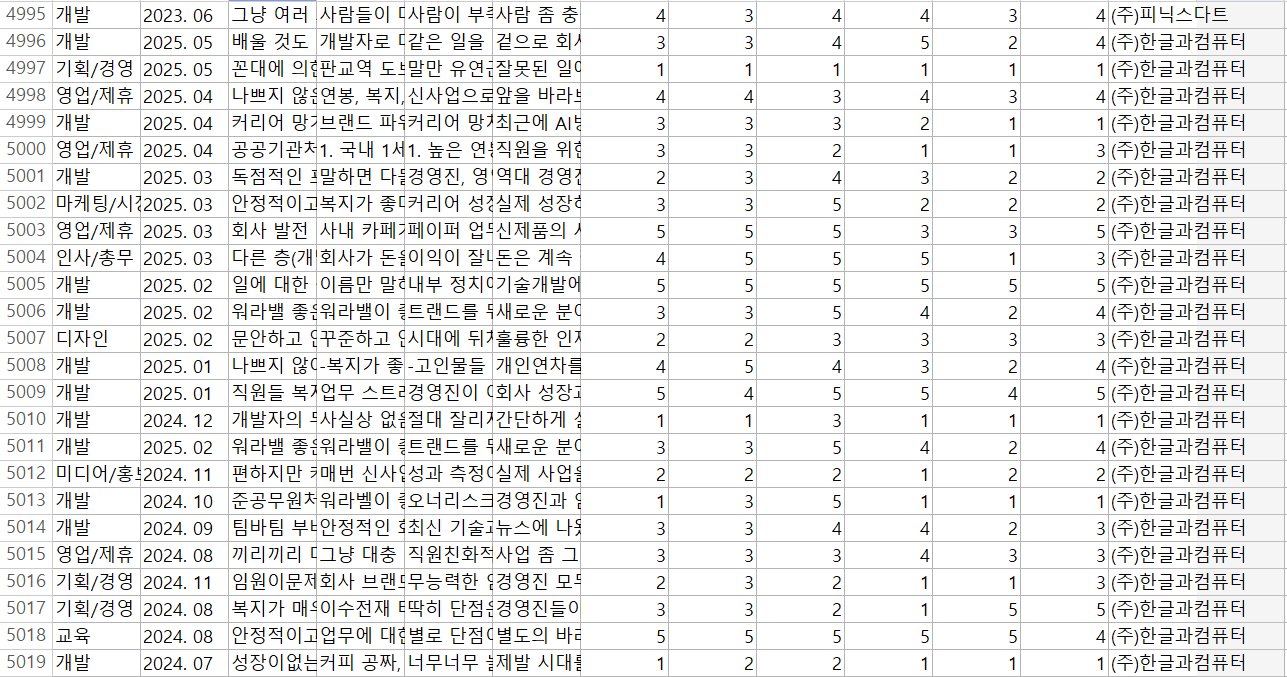

회귀모델을 이용한 분석 코드입니다.

In [3]:
# 필요한 라이브러리
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Excel 파일 읽기
# 확장자가 .xlsx 이므로 read_excel 사용
file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    data = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 코랩에 파일 업로드.")
    raise
except Exception as e:
    print(f"파일을 읽는 도중 오류가 발생했습니다: {e}")
    raise

# 2. 데이터 전처리
# 열 이름 앞뒤 공백 제거 (오류 방지)
data.columns = [str(col).strip() for col in data.columns]

# 원본 파일에 존재하는 실제 열 이름 목록
expected_cols = [
    '구분',             # role_category
    '복지 및 급여',      # salary_benefits
    '업무와 삶의 균형',  # work_life_balance
    '사내문화',          # culture
    '종합평점',          # overall_rating
    '경영진',            # leadership
    '승진 기회'          # promotion_opportunity
]

# 누락된 열이 있는지 확인
missing_cols = [col for col in expected_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"데이터셋에서 다음 열을 찾을 수 없습니다: {missing_cols}")

# 필요한 열만 추출
df_analysis = data[expected_cols].copy()

# 수치형 데이터로 변환 (혹시 모를 문자열 오기입 방지) 및 결측치 제거
numeric_cols = ['복지 및 급여', '업무와 삶의 균형', '사내문화', '종합평점', '경영진', '승진 기회']
for col in numeric_cols:
    df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')

# 결측치 제거
df_analysis = df_analysis.dropna()

print(f"분석 대상 데이터 수: {len(df_analysis)} 건")

# 3. 변수명 영문 변경 (statsmodels 수식 처리를 위함)
df_analysis = df_analysis.rename(columns={
    '구분': 'role_category',
    '복지 및 급여': 'salary_benefits',
    '업무와 삶의 균형': 'work_life_balance',
    '사내문화': 'culture',
    '종합평점': 'overall_rating',
    '경영진': 'leadership',
    '승진 기회': 'promotion_opportunity'
})

# 4. 회귀모델 적합 (OLS)
# 종속변수: overall_rating (종합평점)
# 독립변수: salary_benefits, work_life_balance, culture, leadership, promotion_opportunity
model = smf.ols('overall_rating ~ salary_benefits + work_life_balance + culture + leadership + promotion_opportunity', data=df_analysis).fit()

# 5. 결과 출력
print(model.summary())

# 6. 가장 영향력이 큰 요소 분석
# Intercept(절편) 제외
coefs = model.params.drop('Intercept')
p_values = model.pvalues.drop('Intercept')

# 절대값 기준으로 가장 영향력이 큰 변수 찾기
most_impactful = coefs.abs().idxmax()
most_impactful_value = coefs[most_impactful]
most_impactful_p = p_values[most_impactful]

# 영문 변수명을 한글로 매핑하여 출력하기 위한 사전
col_map_inv = {
    'salary_benefits': '복지 및 급여',
    'work_life_balance': '업무와 삶의 균형',
    'culture': '사내문화',
    'leadership': '경영진',
    'promotion_opportunity': '승진 기회'
}

print("\n" + "="*50)
print("[분석 결과: 종합평점에 가장 큰 영향을 미치는 요소]")
print(f"가장 영향력 있는 요소 : {col_map_inv.get(most_impactful, most_impactful)}")
print(f"회귀 계수 (Coefficient): {most_impactful_value:.4f}")
print(f"  -> 설명: 다른 조건이 동일할 때, 이 항목이 1점 오르면 종합평점은 약 {most_impactful_value:.2f}점 {'상승' if most_impactful_value > 0 else '하락'}합니다.")
print(f"P-value (유의확률)    : {most_impactful_p:.4f} ({'통계적으로 유의미함' if most_impactful_p < 0.05 else '통계적으로 유의미하지 않음'})")
print("="*50)

분석 대상 데이터 수: 5599 건
                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     3106.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:50:48   Log-Likelihood:                -5618.9
No. Observations:                5599   AIC:                         1.125e+04
Df Residuals:                    5593   BIC:                         1.129e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

이상의 데이터로 종합평점에 대한 회귀분석을 진행한 결과는 다음과 같습니다.


OLS 회귀분석 결과에 대한 요약입니다.


###
**1.모델의 설명력 (R-squared: 0.735)**

이 모델은 매우 높은 설명력을 가지고 있습니다.

5가지 요소(급여, 워라밸, 문화, 경영진, 승진)가 종합평점 변동의 약 73.5%를 설명하고 있습니다. 즉, 이 5가지 항목만 알면 해당 기업의 종합평점을 상당히 정확하게 예측할 수 있다는 뜻입니다.


###

**2.요소별 영향력 순위 (회귀계수 기준)** 종합평점에 미치는 영향이 큰 순서대로 나열하면 다음과 같습니다. (모두 통계적으로 유의미함, P < 0.000)

(1) 경영진 (Leadership): 0.3087 (가장 강력한 영향)

(2) 사내문화 (Culture): 0.2302

(3) 승진 기회 (Promotion Opportunity): 0.1998

(4) 복지 및 급여 (Salary & Benefits): 0.1738

(5) 업무와 삶의 균형 (Work-Life Balance): 0.1137



**3.해석**

경영진의 중요성: '경영진' 항목의 점수가 1점 오를 때, 종합평점은 약 0.31점 상승합니다. 이는 가장 영향력이 낮은 '워라밸(0.11점)'보다 약 2.7배 더 큰 영향력을 가집니다.

워라밸의 역설: 요즘 청년들이 워라밸을 중요하게 생각한다고 막연하게 생각하는 부분이 있었는데 실제 데이터상으로는 '경영진'이나 '사내문화'가 좋을 때 회사를 더 높게 평가하는 경향이 있을 가능성을 확인했습니다.  워라밸은 기본 조건에 가깝고, 고득점을 결정짓는 것은 리더십과 문화일수 있습니다.

이번 모델 제작을 위한 방향성에서는 살작 벗어나지만, 이 데이터에 따르면, 기업이 종합적인 만족도를 높이기 위해서는 단순히 칼퇴근(워라밸)을 보장하는 것보다, 경영진에 대한 신뢰를 회복하고 긍정적인 사내문화를 조성하는 것이 훨씬 효과적일수도 있습니다. (개인적 견해)



---



직무별로 민감한 요소가 따로 있을거 같아 해당 부분도 데이터 분석을 진행해 보았습니다. 해당 결과를 모델 학습에 어떻게 쓸수 있는지에 대해 더 고민을 해보아야 겠습니다.

In [4]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import defaultdict

# 1. Excel 파일 읽기

file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    data = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 코랩 파일 탭에 업로드되었는지 확인해주세요.")
    raise
except Exception as e:
    print(f"파일 읽기 오류: {e}")
    raise

# 2. 데이터 전처리
# 열 이름 공백 제거
data.columns = [str(col).strip() for col in data.columns]

# 열 이름 매핑 (한글 -> 영문)
column_map = {
    '구분': 'role_category',
    '복지 및 급여': 'salary_benefits',
    '업무와 삶의 균형': 'work_life_balance',
    '사내문화': 'culture',
    '종합평점': 'overall_rating',
    '경영진': 'leadership',
    '승진 기회': 'promotion_opportunity'
}

# 필요한 열 확인 및 선택
expected_cols = list(column_map.keys())
missing_cols = [col for col in expected_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"데이터셋에서 다음 열을 찾을 수 없습니다: {missing_cols}")

df_analysis = data[expected_cols].rename(columns=column_map)

# 수치형 데이터 변환 및 결측치 제거
numeric_cols = ['salary_benefits', 'work_life_balance', 'culture', 'overall_rating', 'leadership', 'promotion_opportunity']
for col in numeric_cols:
    df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')

df_analysis = df_analysis.dropna()

print(f"전체 분석 데이터 수: {len(df_analysis)} 건")

# 3. 직군(Category) 별 회귀분석 수행
categories = df_analysis['role_category'].unique()
impact_group = defaultdict(list)

# 결과 출력용 한글 매핑
col_map_inv = {v: k for k, v in column_map.items()}

print("\n" + "="*60)
print("직군별 종합평점 결정요인 분석 진행 중...")
print("="*60)

for category in categories:
    # 해당 직군 데이터 추출
    subset = df_analysis[df_analysis['role_category'] == category]

    # 데이터가 너무 적으면 회귀분석 신뢰도가 떨어지므로 건너뜀 (예: 10개 미만)
    if len(subset) < 10:
        continue

    try:
        # 모델 적합
        formula = 'overall_rating ~ salary_benefits + work_life_balance + culture + leadership + promotion_opportunity'
        model = smf.ols(formula, data=subset).fit()

        # 계수(Coef) 추출 (Intercept 제외)
        coefs = model.params.drop('Intercept')

        # 가장 영향력 큰 요소 선정 (절대값 기준)
        most_impactful = coefs.abs().idxmax()
        most_impactful_value = coefs[most_impactful]

        # 그룹에 추가
        impact_group[most_impactful].append(category)

        # 진행 상황 출력 (선택적)
        print(f" -> [{category}] (n={len(subset)}) 완료: 주 요인 = {col_map_inv[most_impactful]}")

    except Exception as e:
        print(f" -> [{category}] 분석 실패: {e}")

# 4. 최종 결과 출력: 요소별로 영향을 많이 받은 직렬 묶어서 출력
print("\n" + "="*60)
print("          [최종 결과: 요소별로 종합평점에 가장 큰 영향을 받는 직군]")
print("="*60)

if not impact_group:
    print("분석 가능한 직군이 없거나 데이터가 부족합니다.")
else:
    for factor, roles in impact_group.items():
        factor_korean = col_map_inv.get(factor, factor)
        print(f"\n■ 결정적 요인: {factor_korean} ({factor})")
        print("-" * 40)

        for role in sorted(roles):
            print(f"  - {role}")

print("\n" + "="*60)

전체 분석 데이터 수: 5599 건

직군별 종합평점 결정요인 분석 진행 중...
 -> [영업/제휴] (n=470) 완료: 주 요인 = 경영진
 -> [유통/무역] (n=97) 완료: 주 요인 = 사내문화
 -> [생산관리/품질관리] (n=91) 완료: 주 요인 = 복지 및 급여
 -> [인사/총무] (n=123) 완료: 주 요인 = 경영진
 -> [생산/제조] (n=115) 완료: 주 요인 = 경영진
 -> [기획/경영] (n=800) 완료: 주 요인 = 경영진
 -> [서비스/고객지원] (n=301) 완료: 주 요인 = 사내문화
 -> [디자인] (n=349) 완료: 주 요인 = 경영진
 -> [개발] (n=1481) 완료: 주 요인 = 경영진
 -> [마케팅/시장조사] (n=946) 완료: 주 요인 = 경영진
 -> [전문직] (n=32) 완료: 주 요인 = 경영진
 -> [미디어/홍보] (n=278) 완료: 주 요인 = 경영진
 -> [데이터] (n=108) 완료: 주 요인 = 경영진
 -> [금융/재무] (n=111) 완료: 주 요인 = 경영진
 -> [교육] (n=94) 완료: 주 요인 = 경영진
 -> [연구개발] (n=115) 완료: 주 요인 = 복지 및 급여
 -> [엔지니어링] (n=37) 완료: 주 요인 = 경영진
 -> [현직원 설문] (n=37) 완료: 주 요인 = 경영진

          [최종 결과: 요소별로 종합평점에 가장 큰 영향을 받는 직군]

■ 결정적 요인: 경영진 (leadership)
----------------------------------------
  - 개발
  - 교육
  - 금융/재무
  - 기획/경영
  - 데이터
  - 디자인
  - 마케팅/시장조사
  - 미디어/홍보
  - 생산/제조
  - 엔지니어링
  - 영업/제휴
  - 인사/총무
  - 전문직
  - 현직원 설문

■ 결정적 요인: 사내문화 (culture)
----------------------------------------
  - 서



---



이상의 결과를 히트맵으로 시각화 한 것입니다.

전체 분석 데이터 수: 5599 건

직군별 종합평점 결정요인 분석 진행 중...
 -> [영업/제휴] (n=470) 분석 완료
 -> [유통/무역] (n=97) 분석 완료
 -> [생산관리/품질관리] (n=91) 분석 완료
 -> [인사/총무] (n=123) 분석 완료
 -> [생산/제조] (n=115) 분석 완료
 -> [기획/경영] (n=800) 분석 완료
 -> [서비스/고객지원] (n=301) 분석 완료
 -> [디자인] (n=349) 분석 완료
 -> [개발] (n=1481) 분석 완료
 -> [마케팅/시장조사] (n=946) 분석 완료
 -> [전문직] (n=32) 분석 완료
 -> [미디어/홍보] (n=278) 분석 완료
 -> [데이터] (n=108) 분석 완료
 -> [금융/재무] (n=111) 분석 완료
 -> [교육] (n=94) 분석 완료
 -> [연구개발] (n=115) 분석 완료
 -> [엔지니어링] (n=37) 분석 완료
 -> [현직원 설문] (n=37) 분석 완료

          [최종 결과: 요소별로 종합평점에 가장 큰 영향을 받는 직군]

■ 결정적 요인: 경영진 (leadership)
----------------------------------------
  - 개발
  - 교육
  - 금융/재무
  - 기획/경영
  - 데이터
  - 디자인
  - 마케팅/시장조사
  - 미디어/홍보
  - 생산/제조
  - 엔지니어링
  - 영업/제휴
  - 인사/총무
  - 전문직
  - 현직원 설문

■ 결정적 요인: 사내문화 (culture)
----------------------------------------
  - 서비스/고객지원
  - 유통/무역

■ 결정적 요인: 복지 및 급여 (salary_benefits)
----------------------------------------
  - 생산관리/품질관리
  - 연구개발

직무별 상관관계 히트맵을 생성합니다...


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

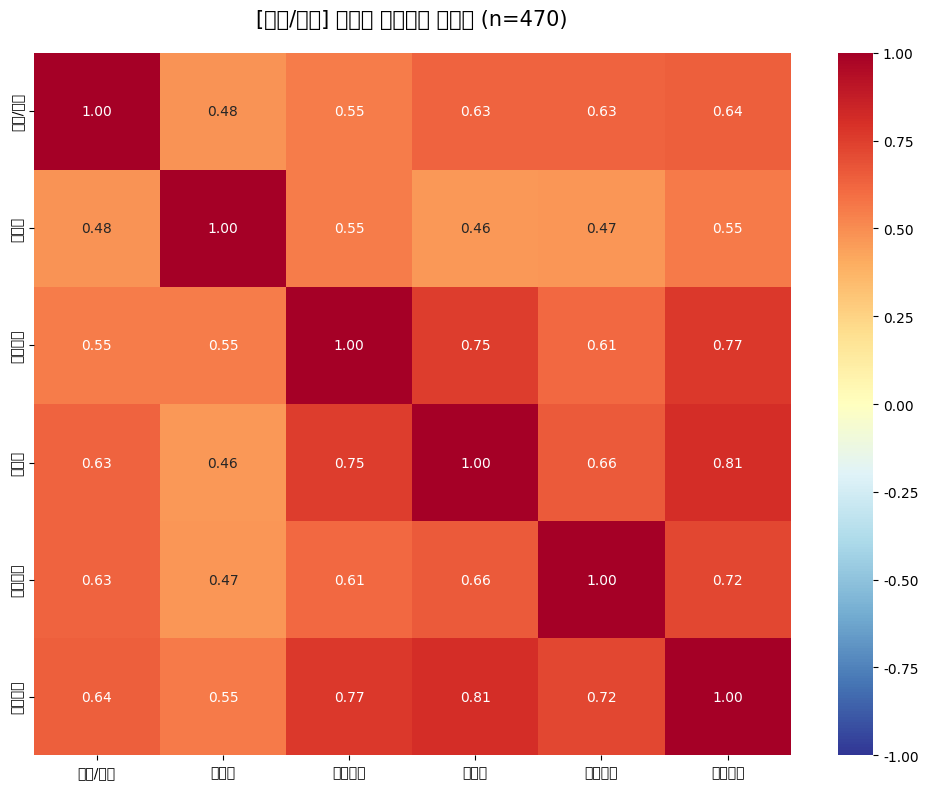

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 영업/제휴 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

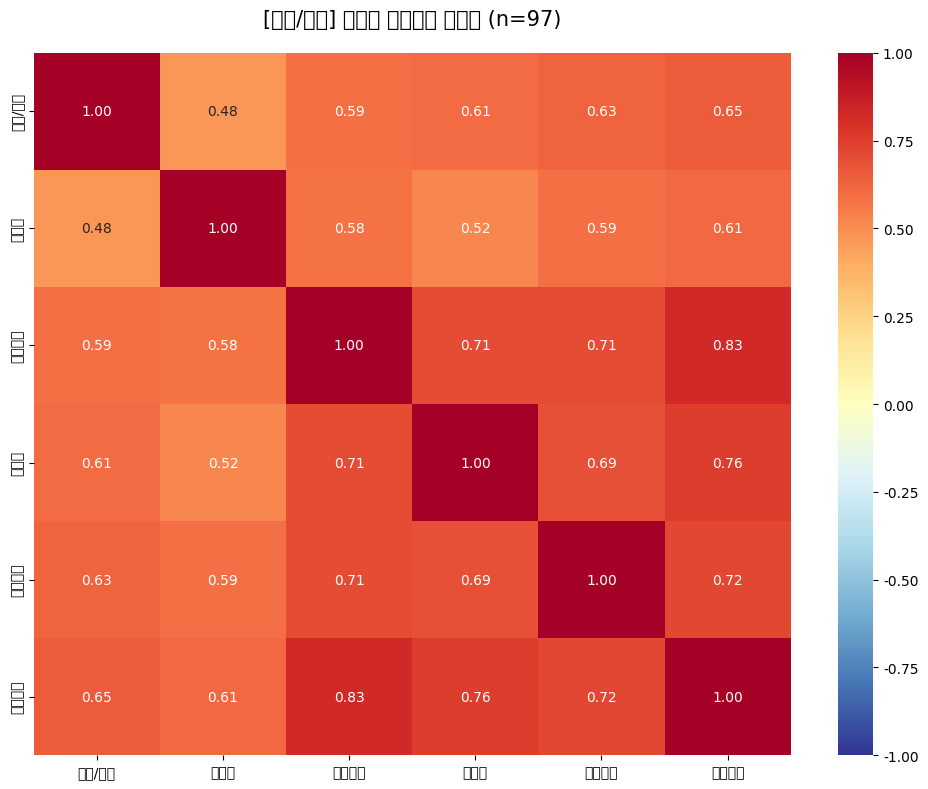

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 유통/무역 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

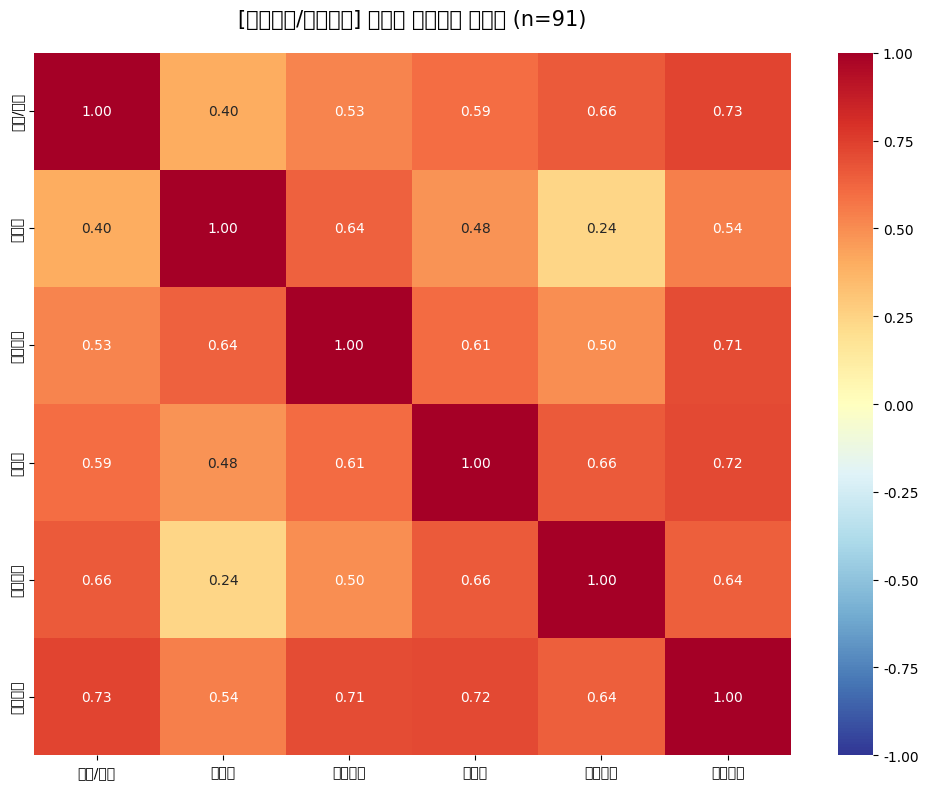

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 생산관리/품질관리 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

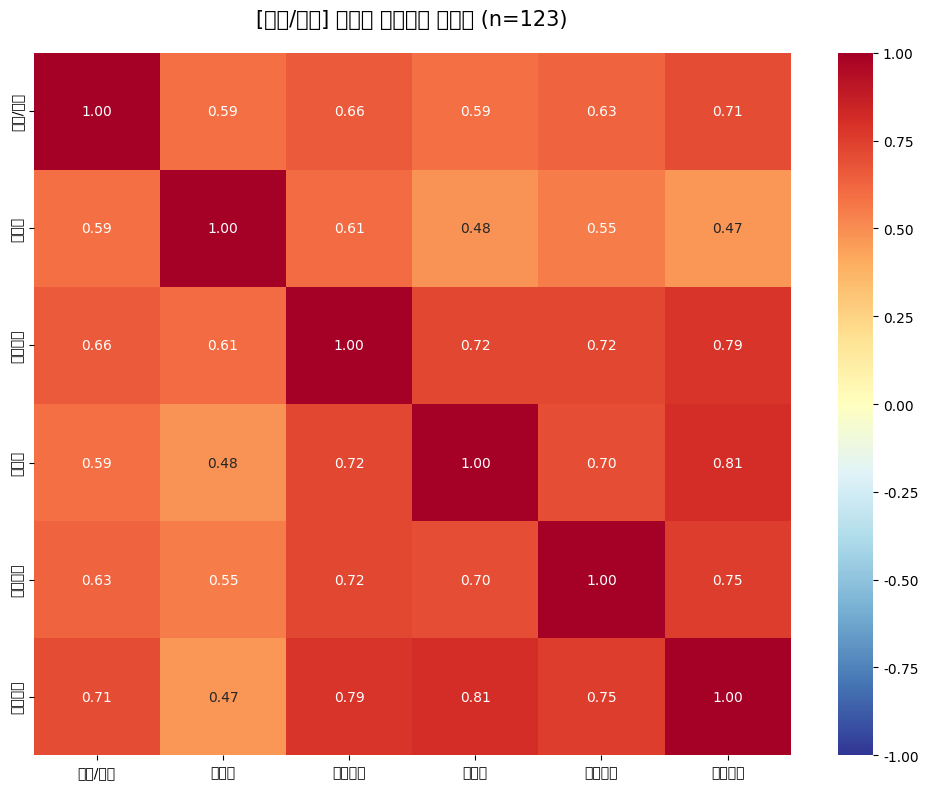

 -> 인사/총무 히트맵 출력 완료


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

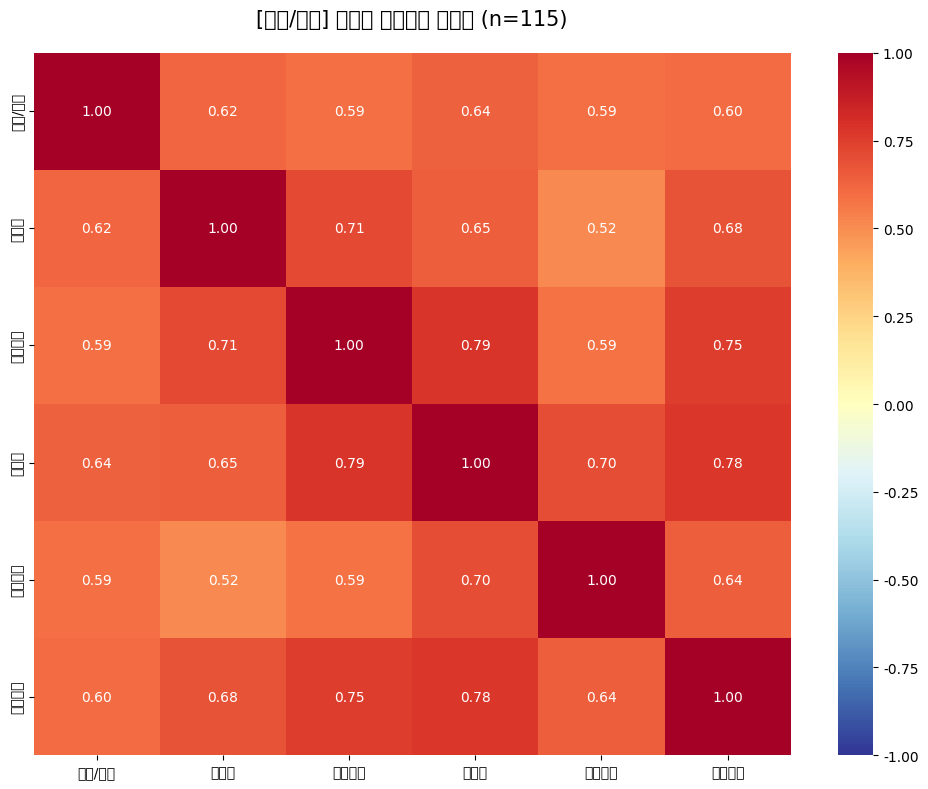

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 생산/제조 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 54925 (\N{HANGUL SYLLABLE HOEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_lay

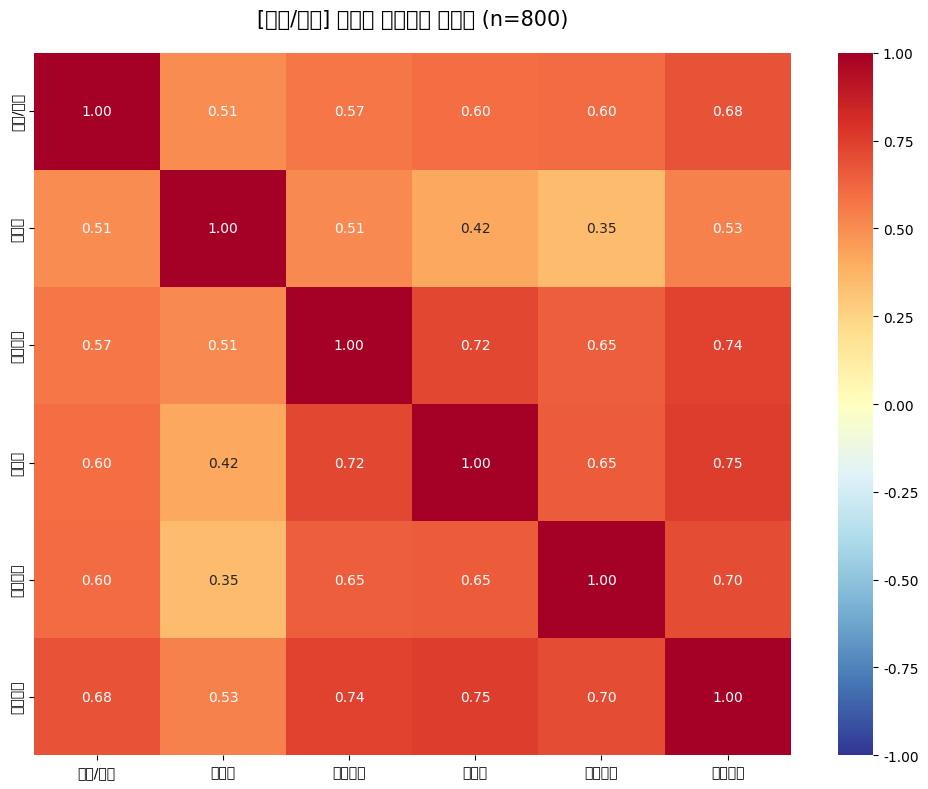

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 기획/경영 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


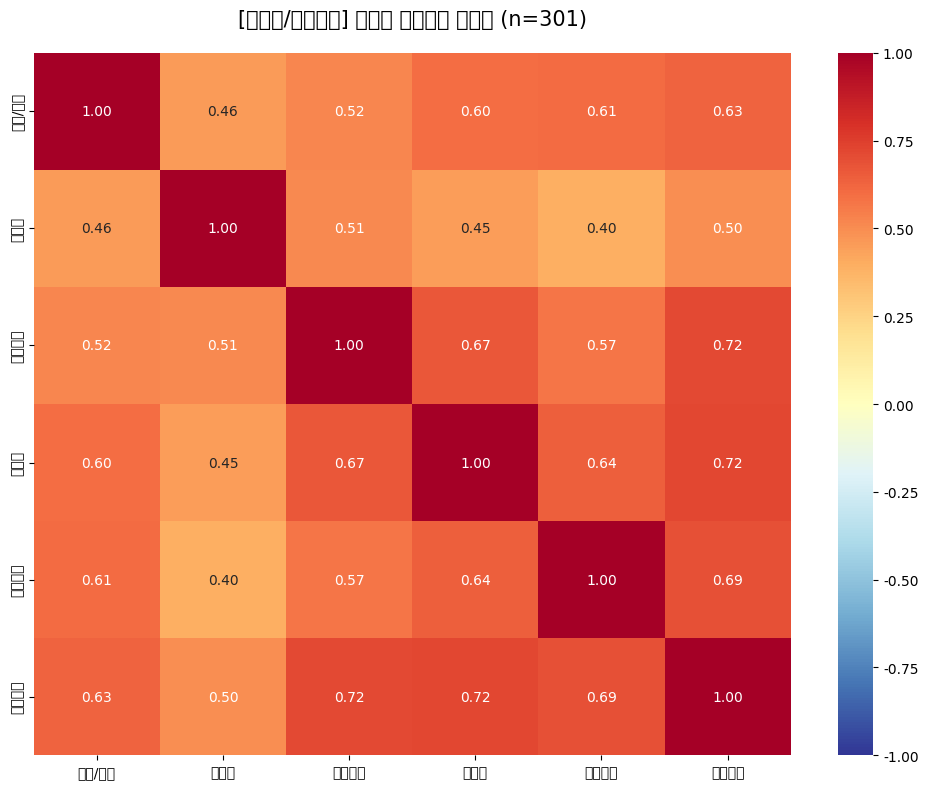

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 서비스/고객지원 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

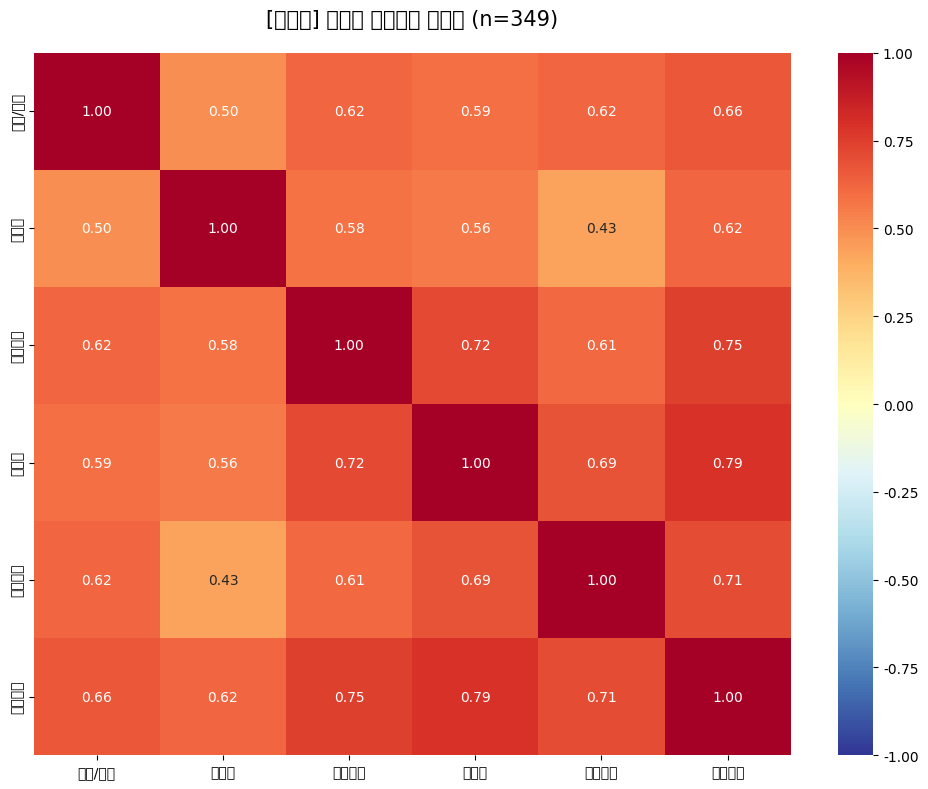

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 디자인 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout

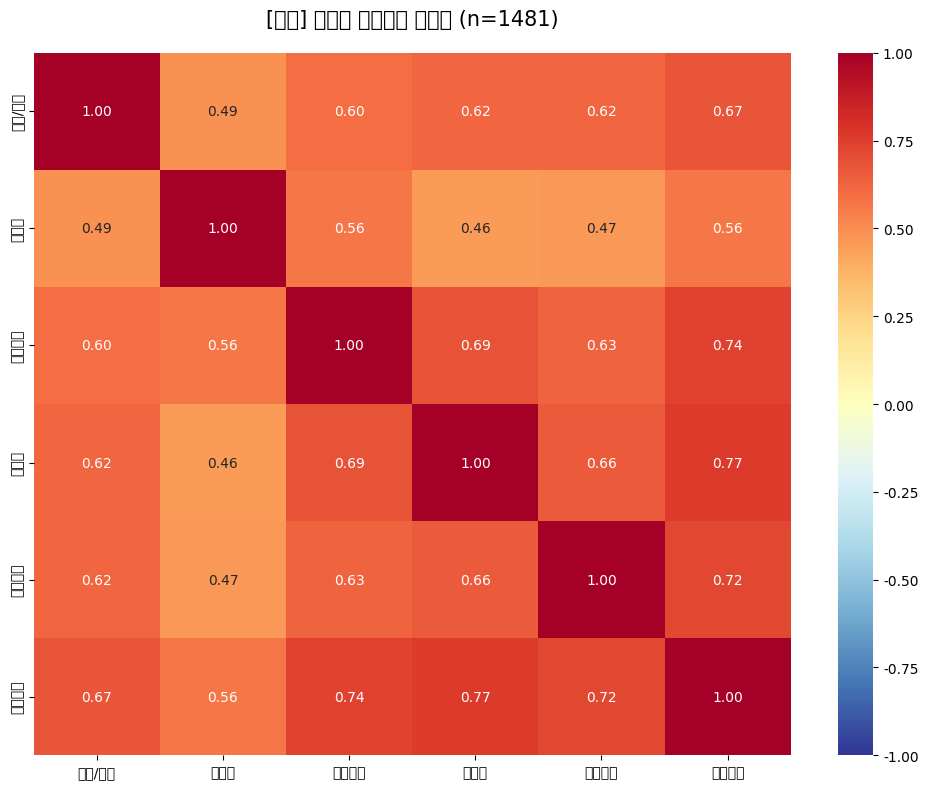

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 개발 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 54021 (\N{HANGUL SYLLABLE TING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/t

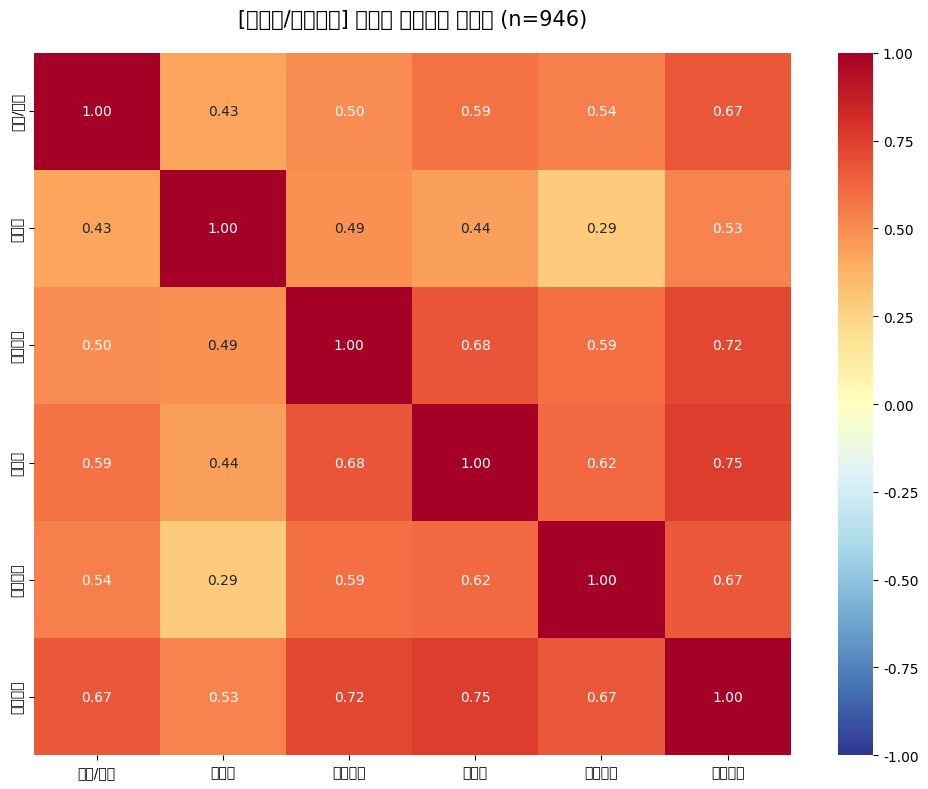

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 마케팅/시장조사 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51649 (\N{HANGUL SYLLABLE JIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout

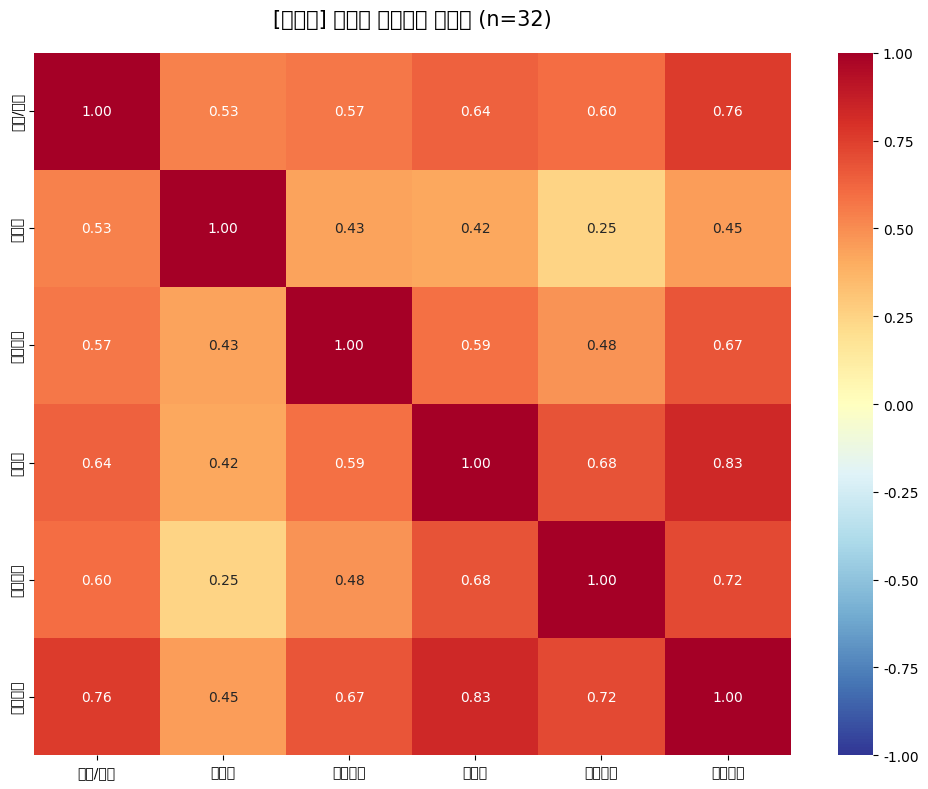

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 전문직 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 54861 (\N{HANGUL SYLLABLE HONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

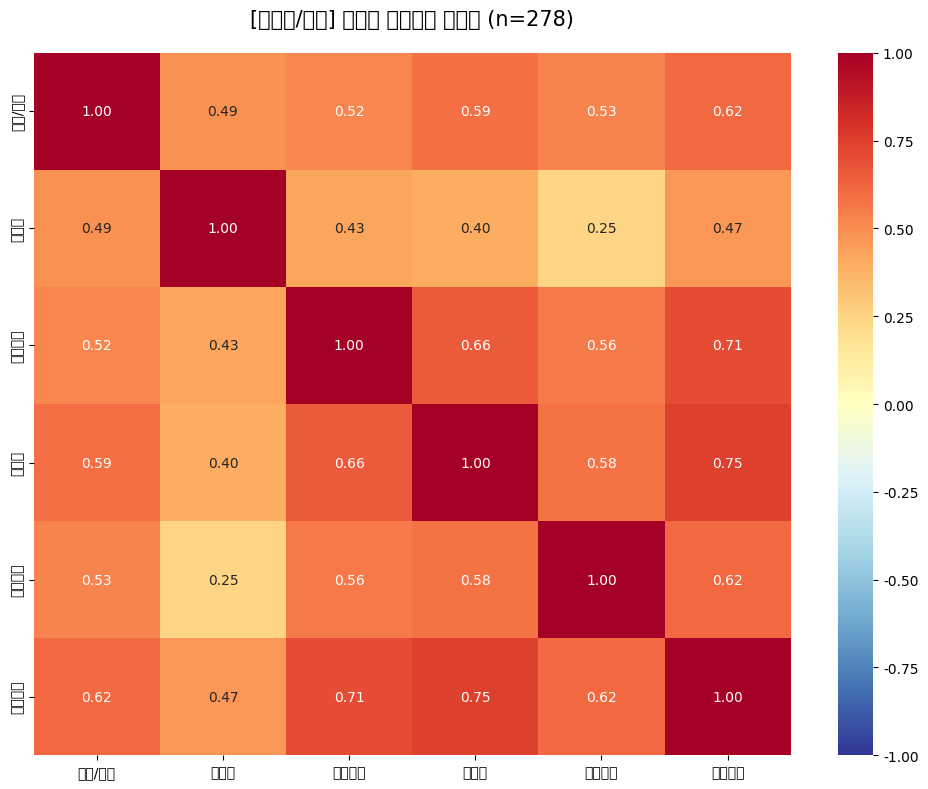

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 미디어/홍보 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

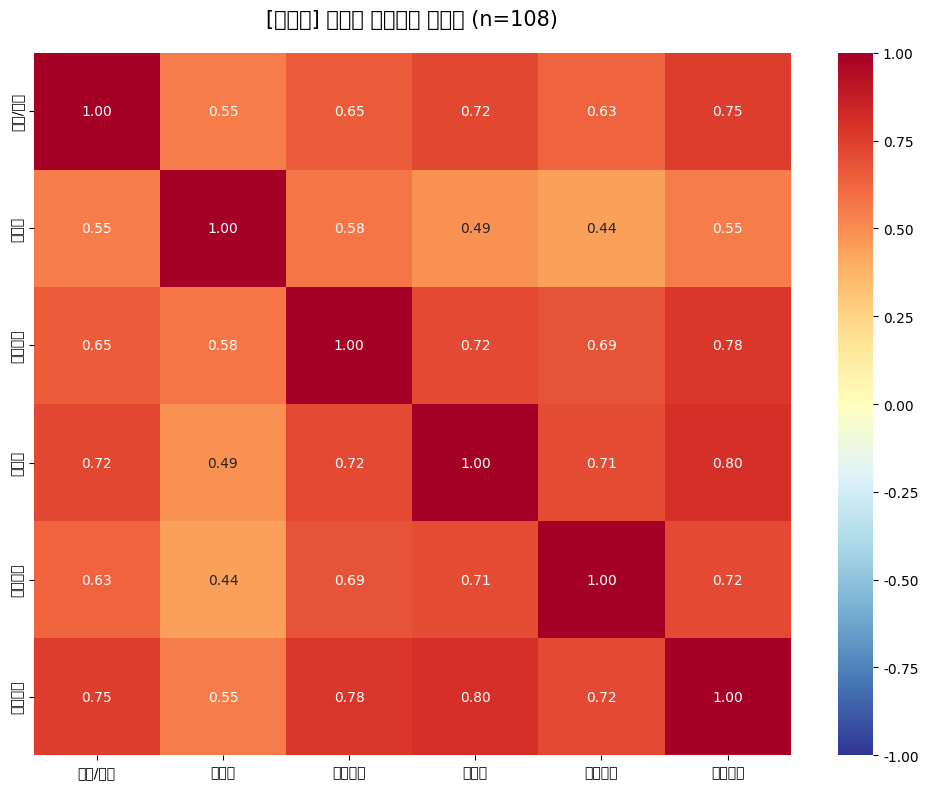

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 데이터 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50997 (\N{HANGUL SYLLABLE YUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

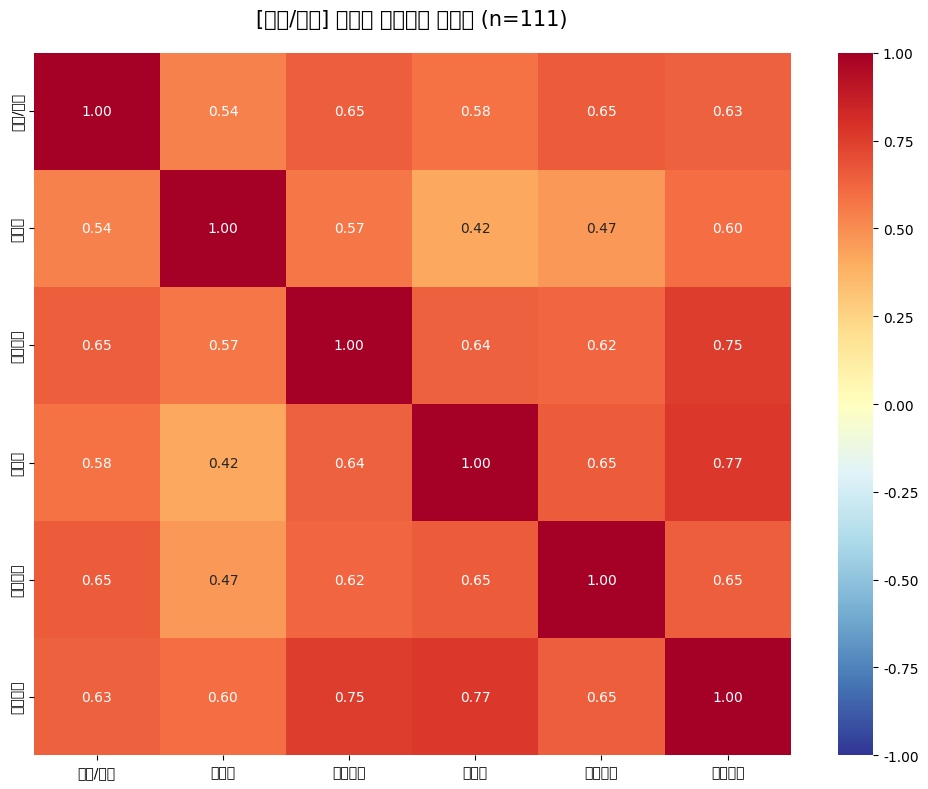

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 금융/재무 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50977 (\N{HANGUL SYLLABLE YUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout

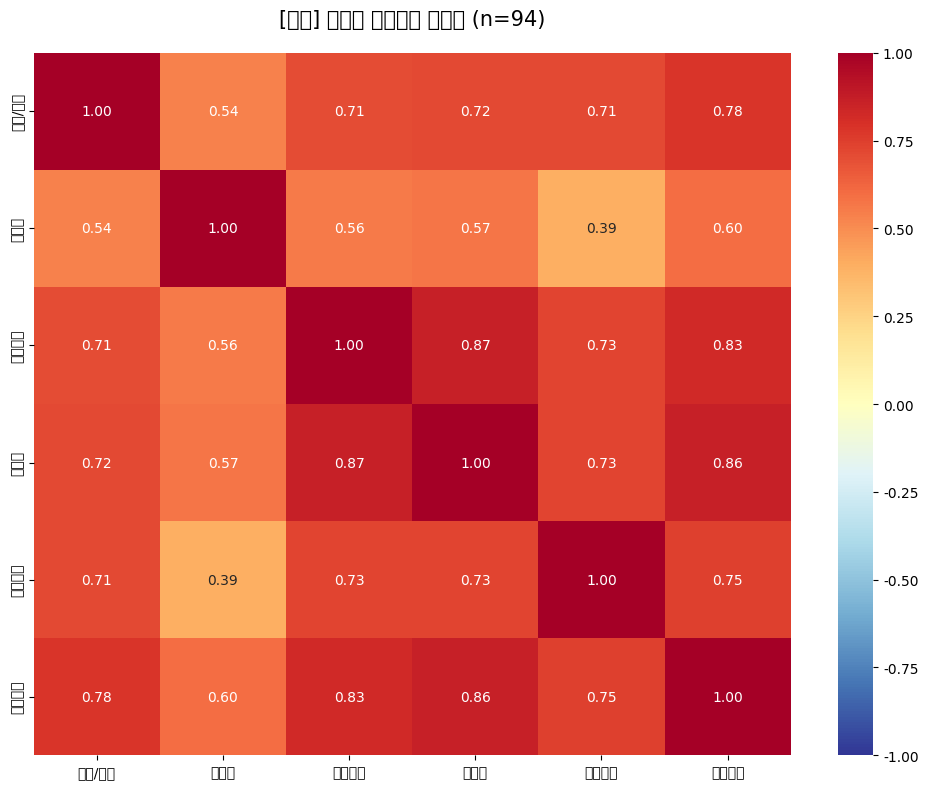

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 교육 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

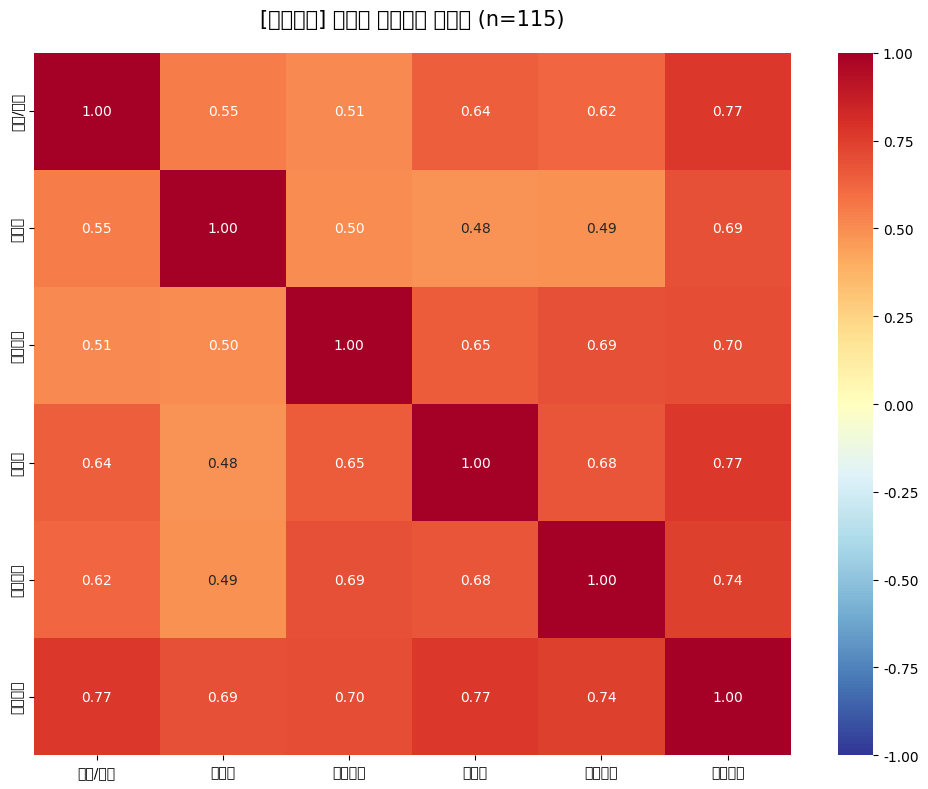

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 연구개발 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50644 (\N{HANGUL SYLLABLE EN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47553 (\N{HANGUL SYLLABLE RING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

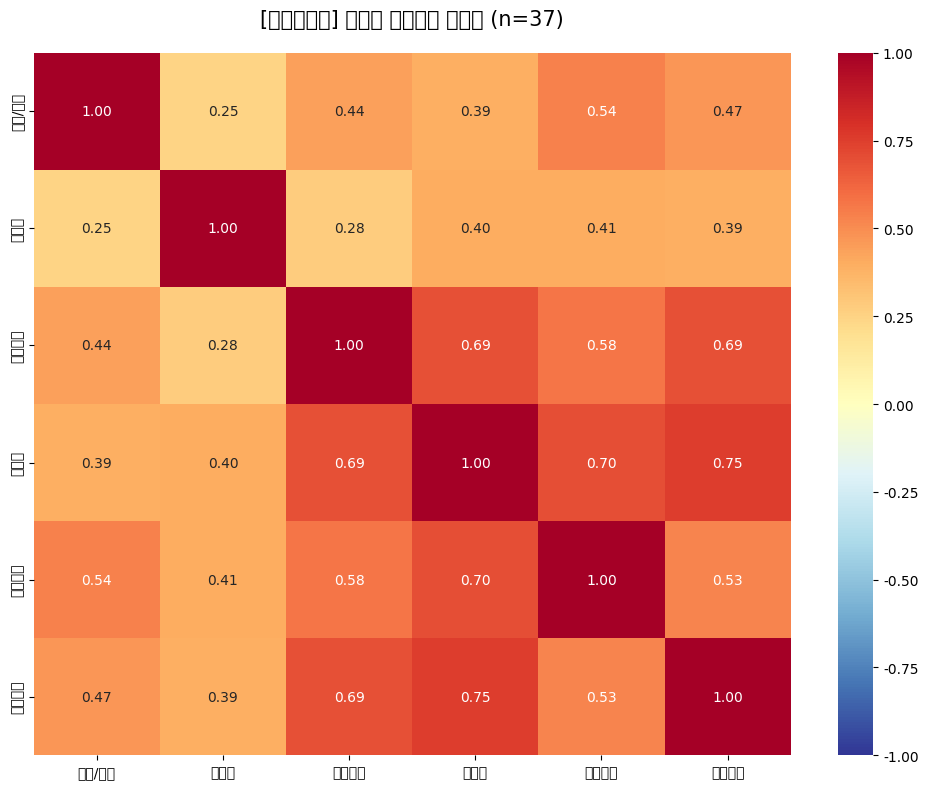

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

 -> 엔지니어링 히트맵 출력 완료


/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 51649 (\N{HANGUL SYLLABLE JIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-611830999.py:144: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout

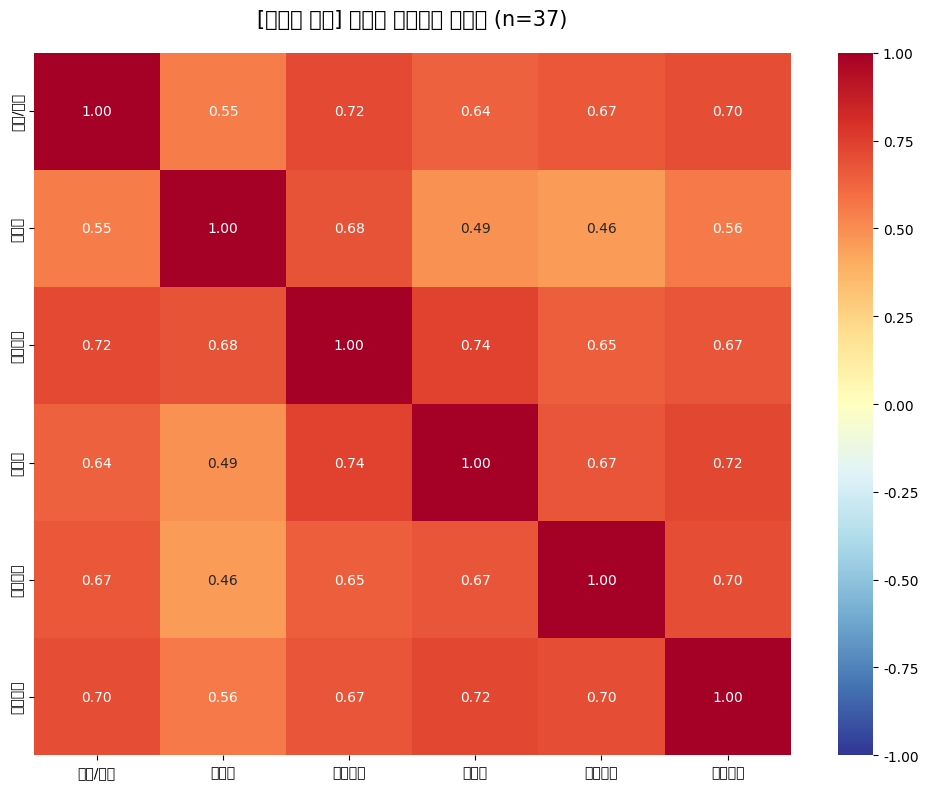

 -> 현직원 설문 히트맵 출력 완료

모든 작업이 완료되었습니다.


In [5]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# ==========================================
# 0. 한글 폰트 설정 (깨지는 경우가 다수..)
# ==========================================
def set_korean_font():
    # 운영체제별 폰트 설정
    if os.name == 'posix':
        # 나눔폰트 설치 여부
        try:
            # 코랩에 나눔폰트가 설치되어 있다고 가정하고 설정
            plt.rc('font', family='NanumBarunGothic')
        except:
            plt.rc('font', family='AppleGothic')
    elif os.name == 'nt':
        plt.rc('font', family='Malgun Gothic')

    # 마이너스 부호 깨짐 방지
    plt.rc('axes', unicode_minus=False)

set_korean_font()

# 1. Excel 파일 읽기
file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    data = pd.read_excel(file_path)
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 코랩 파일 탭에 업로드되었는지 확인해주세요.")
    # 코랩에서 한글 폰트 설치가 기본으로 안 된다면?
    print("TIP: 코랩에서 한글이 깨진다면 다음 코드를 먼저 실행하고 런타임을 재시작하세요:\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf")
    raise
except Exception as e:
    print(f"파일 읽기 오류: {e}")
    raise

# 2. 데이터 전처리
data.columns = [str(col).strip() for col in data.columns]

column_map = {
    '구분': 'role_category',
    '복지 및 급여': 'salary_benefits',
    '업무와 삶의 균형': 'work_life_balance',
    '사내문화': 'culture',
    '종합평점': 'overall_rating',
    '경영진': 'leadership',
    '승진 기회': 'promotion_opportunity'
}

expected_cols = list(column_map.keys())
missing_cols = [col for col in expected_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"데이터셋에서 다음 열을 찾을 수 없습니다: {missing_cols}")

df_analysis = data[expected_cols].rename(columns=column_map)

numeric_cols = ['salary_benefits', 'work_life_balance', 'culture', 'overall_rating', 'leadership', 'promotion_opportunity']
for col in numeric_cols:
    df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')

df_analysis = df_analysis.dropna()

print(f"전체 분석 데이터 수: {len(df_analysis)} 건")

# 3. 직군(Category) 별 회귀분석 수행
categories = df_analysis['role_category'].unique()
impact_group = defaultdict(list)
col_map_inv = {v: k for k, v in column_map.items()}

print("\n" + "="*60)
print("직군별 종합평점 결정요인 분석 진행 중...")
print("="*60)

for category in categories:
    subset = df_analysis[df_analysis['role_category'] == category]
    if len(subset) < 10: continue

    try:
        formula = 'overall_rating ~ salary_benefits + work_life_balance + culture + leadership + promotion_opportunity'
        model = smf.ols(formula, data=subset).fit()

        coefs = model.params.drop('Intercept')
        most_impactful = coefs.abs().idxmax()
        impact_group[most_impactful].append(category)

        print(f" -> [{category}] (n={len(subset)}) 분석 완료")
    except Exception as e:
        print(f" -> [{category}] 분석 실패: {e}")

# 4. 결과 요약 출력
print("\n" + "="*60)
print("          [최종 결과: 요소별로 종합평점에 가장 큰 영향을 받는 직군]")
print("="*60)

if not impact_group:
    print("분석 가능한 직군이 없거나 데이터가 부족합니다.")
else:
    for factor, roles in impact_group.items():
        factor_korean = col_map_inv.get(factor, factor)
        print(f"\n■ 결정적 요인: {factor_korean} ({factor})")
        print("-" * 40)
        for role in sorted(roles):
            print(f"  - {role}")

# ==========================================
# 5. 직군별 히트맵(Heatmap) 시각화
# ==========================================
print("\n" + "="*60)
print("직무별 상관관계 히트맵을 생성합니다...")
print("="*60)

# 히트맵에 사용할 변수와 한글 라벨 정의
heatmap_cols = ['salary_benefits', 'work_life_balance', 'culture', 'leadership', 'promotion_opportunity', 'overall_rating']
heatmap_labels = ['복지/급여', '워라밸', '사내문화', '경영진', '승진기회', '종합평점']

for category in categories:
    subset = df_analysis[df_analysis['role_category'] == category]

    # 데이터가 너무 적으면 시각화 건너뜀
    if len(subset) < 10:
        continue

    # 상관관계 행렬 계산
    corr_matrix = subset[heatmap_cols].corr()

    # 히트맵 그리기
    plt.figure(figsize=(10, 8))
    sns.heatmap(data=corr_matrix,
                annot=True,         # 숫자 표시
                fmt='.2f',          # 소수점 2자리
                cmap='RdYlBu_r',    # 색상 테마 (빨강-노랑-파랑 역순: 파란색이 양의 상관관계)
                vmin=-1, vmax=1,    # 상관계수 범위 (-1 ~ 1)
                xticklabels=heatmap_labels,
                yticklabels=heatmap_labels)

    plt.title(f'[{category}] 요소별 상관관계 히트맵 (n={len(subset)})', fontsize=15, pad=20)
    plt.tight_layout()
    plt.show()
    print(f" -> {category} 히트맵 출력 완료")

print("\n모든 작업이 완료되었습니다.")

한글 폰트 문제를 아직 해결하지 못했습니다. 해결 방법을 계속 강구해 보겠습니다.



---



추가적으로 PCA 분석을 진행해 보았습니다.

PCA는 이 고차원(6차원) 데이터를 중요한 정보(분산을 많이 설명하는 방향) 위주로 재구성하여,

2차원·3차원 같은 저차원 공간에 투영(Projection) 시켜주는 기법입니다.

이렇게 하면 점들(관찰 단위들)이 “현실 데이터 상에서 서로 얼마나 비슷한지” 혹은 “어떤 그룹/패턴이 있는지”를 상관관계를 완화하여 시각적으로 쉽게 확인할 수 있음을 배웠습니다.

File loaded successfully!
Number of groups (Company_Role): 986

■ Explained Variance Ratio
 PC1 : 0.7092 (70.9% explained)
 PC2 : 0.0997 (10.0% explained)
 -> Total Cumulative Variance: 80.9%

■ PCA Loadings
                         PC1    PC2
salary_benefits        0.387 -0.083
work_life_balance      0.341  0.898
culture                0.428  0.022
leadership             0.427 -0.254
promotion_opportunity  0.409 -0.339
overall_rating         0.449 -0.082


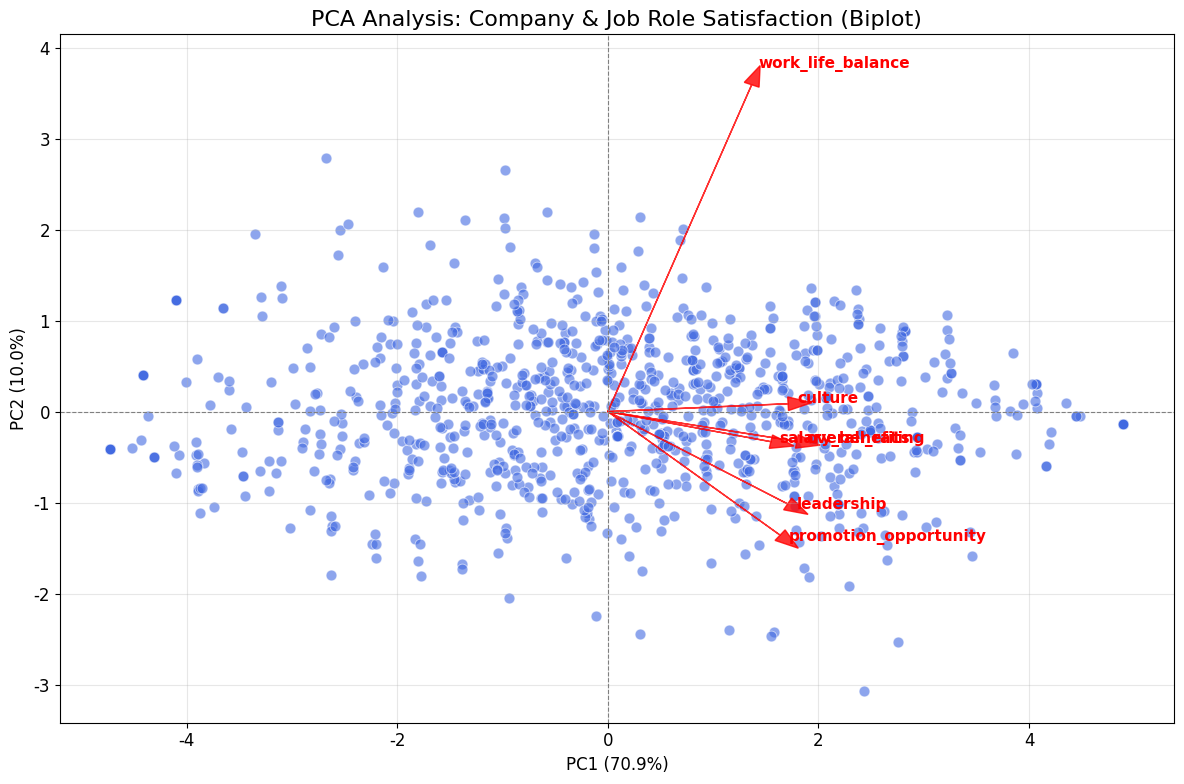

In [7]:
# 필요한 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ==========================================
# 0. 폰트 설정 (기본 영문 폰트 사용, 폰트 깨짐 방지.)
# ==========================================
# 한글 폰트 설정을 제거하고 기본값(영문)을 사용합니다.
plt.rcParams.update({'font.size': 12})

# 1. 데이터 로드
file_path = "통합_리뷰_기업중복제거.xlsx"

try:
    # 엑셀 파일 읽기
    df = pd.read_excel(file_path)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
    raise

# 2. 데이터 전처리
# 열 이름 공백 제거
df.columns = [str(col).strip() for col in df.columns]

# 열 이름 영문 변환 및 매핑 확인
rename_map = {
    '구분': 'job_role',
    '기업명': 'company',
    '복지 및 급여': 'salary_benefits',
    '업무와 삶의 균형': 'work_life_balance',
    '사내문화': 'culture',
    '경영진': 'leadership',
    '승진 기회': 'promotion_opportunity',
    '종합평점': 'overall_rating'
}

# 필수 열 존재 여부 확인
missing_cols = [col for col in rename_map.keys() if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

df = df.rename(columns=rename_map)

# 수치형 데이터 변환 (오류 방지)
score_cols = ['salary_benefits', 'work_life_balance', 'culture', 'leadership', 'promotion_opportunity', 'overall_rating']
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 결측치 제거
df = df.dropna(subset=score_cols + ['company', 'job_role'])

# "회사_직무" 고유 ID 생성 (데이터 처리용, 시각화 라벨로는 사용 안 함)
df['job_company'] = df['company'] + "_" + df['job_role']

# 3. 그룹별 평균 집계 (PCA 분석 대상)
summary_df = df.groupby('job_company')[score_cols].mean().reset_index()

print(f"Number of groups (Company_Role): {len(summary_df)}")

# 4. PCA 분석 수행

# (1) 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(summary_df[score_cols])

# (2) PCA 모델 적합 (주성분 2개)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# (3) 결과 저장
summary_df['PC1'] = pca_result[:, 0]
summary_df['PC2'] = pca_result[:, 1]

# 5. 분석 결과 출력

# (1) 주성분 설명력
print("\n" + "="*50)
print("■ Explained Variance Ratio")
print("="*50)
for idx, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f" PC{idx} : {ratio:.4f} ({ratio*100:.1f}% explained)")

total_variance = sum(pca.explained_variance_ratio_)
print(f" -> Total Cumulative Variance: {total_variance*100:.1f}%")

# (2) 주성분 부하량
loadings = pd.DataFrame(
    pca.components_.T,
    index=score_cols,
    columns=['PC1', 'PC2']
)

print("\n" + "="*50)
print("■ PCA Loadings")
print("="*50)
print(loadings.round(3))

# 6. 시각화 (Scatter Plot with English Labels)
plt.figure(figsize=(12, 8))

# 산점도 그리기
sns.scatterplot(
    data=summary_df,
    x='PC1',
    y='PC2',
    alpha=0.6,
    s=60,
    color='royalblue'
)

# 중심점(0,0) 표시
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

# 로딩 벡터(화살표) 표시
for i, v in enumerate(score_cols):
    # 화살표 그리기
    plt.arrow(0, 0, pca.components_[0, i]*4, pca.components_[1, i]*4,
              color='red', alpha=0.8, head_width=0.15)
    # 변수명 텍스트 (English variable names used)
    plt.text(pca.components_[0, i]*4.2, pca.components_[1, i]*4.2, v,
             color='red', fontsize=11, fontweight='bold')

# 제목 및 축 라벨을 영어로 설정
plt.title('PCA Analysis: Company & Job Role Satisfaction (Biplot)', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

이 표에서 각 행(원래 변수)과 열(PC축)의 값은 “원래 변수 X가 PC축에 얼마나 기여(loading)하는가”를 나타냅니다.

주성분 부하량은 각 축에 기여하는 요소가 어떤 것들이 있는지를 나타냅니다.


여기서 추가적으로 이 PCA 분석 결과에서 모델 학습에 도움이 되는 좀 더 의미있는 결과를 도출하기 위하여 군집 분석을 진행하였습니다. 총 4개의 군집으로 분류했습니다.

File loaded successfully!
Number of groups: 986

■ Explained Variance Ratio
 PC1 : 0.7092 (70.9%)
 PC2 : 0.0997 (10.0%)

■ PCA Loadings (Meaning of Axes)
                         PC1    PC2
salary_benefits        0.387 -0.083
work_life_balance      0.341  0.898
culture                0.428  0.022
leadership             0.427 -0.254
promotion_opportunity  0.409 -0.339
overall_rating         0.449 -0.082

■ Cluster Characteristics (Average Scores)
         salary_benefits  work_life_balance  culture  leadership  \
Cluster                                                            
0                   1.54               1.71     1.46        1.23   
1                   3.88               4.08     4.24        3.96   
2                   3.20               3.44     3.34        2.83   
3                   2.61               2.81     2.43        2.04   

         promotion_opportunity  overall_rating  
Cluster                                         
0                         1.49            1

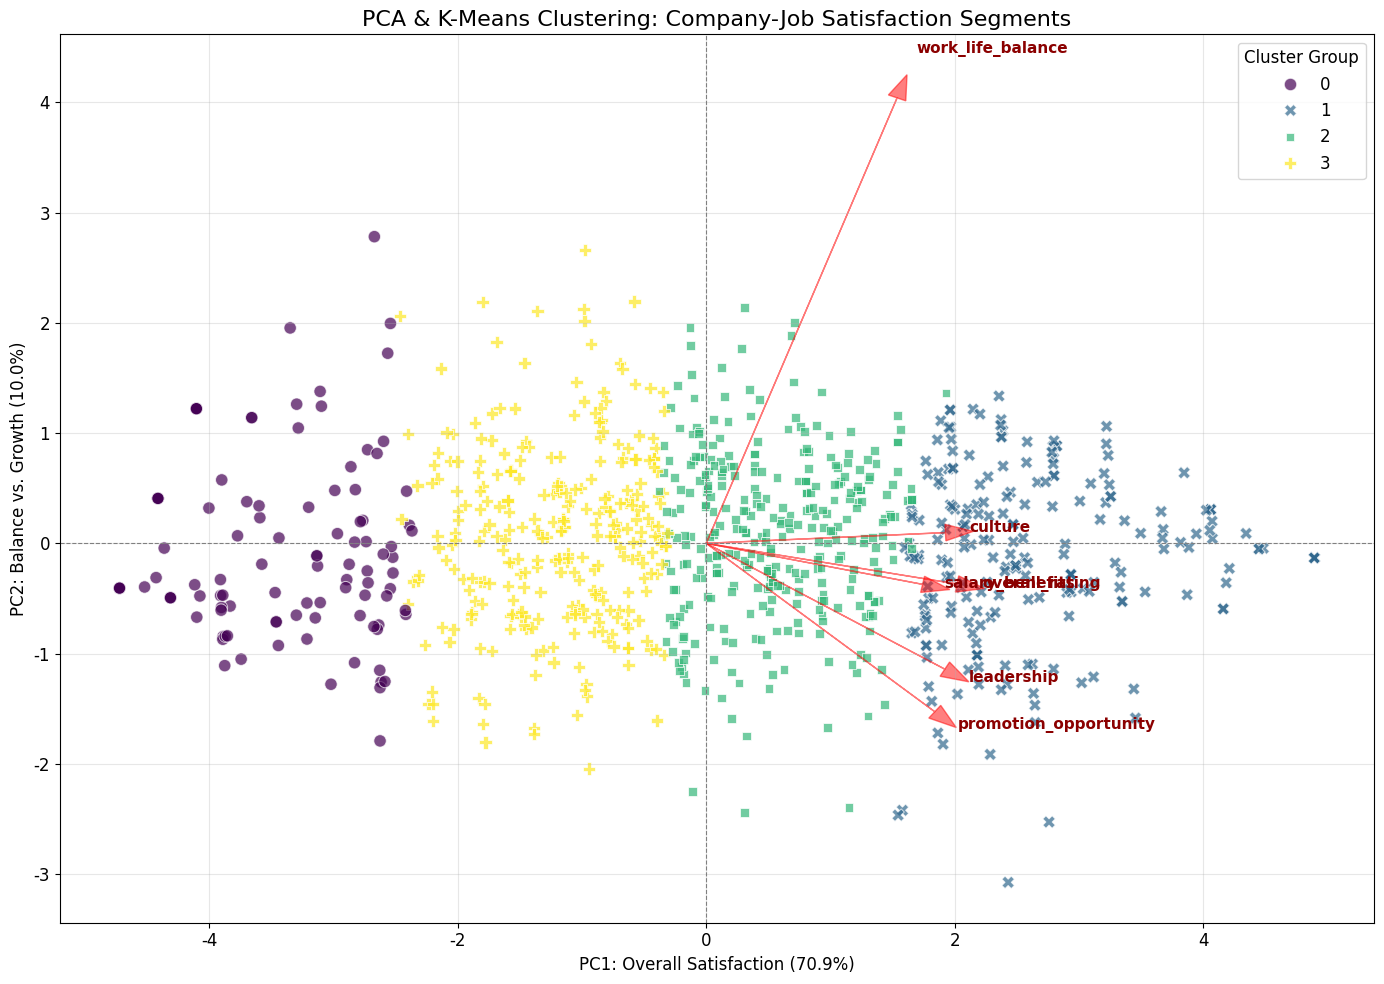

In [9]:
# 필요한 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings  # 경고 제어용

# ==========================================
# 0. 폰트 설정 및 경고 메시지 차단
# ==========================================

warnings.filterwarnings("ignore")

# 기본 영문 폰트 사용 (sans-serif)
plt.rcParams.update({'font.family': 'sans-serif', 'font.size': 12})
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# 1. 데이터 로드
file_path = "통합_리뷰_기업중복제거.xlsx"

try:
    df = pd.read_excel(file_path)
    print("File loaded successfully!")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
    raise

# 2. 데이터 전처리
df.columns = [str(col).strip() for col in df.columns]

rename_map = {
    '구분': 'job_role',
    '기업명': 'company',
    '복지 및 급여': 'salary_benefits',
    '업무와 삶의 균형': 'work_life_balance',
    '사내문화': 'culture',
    '경영진': 'leadership',
    '승진 기회': 'promotion_opportunity',
    '종합평점': 'overall_rating'
}

missing_cols = [col for col in rename_map.keys() if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

df = df.rename(columns=rename_map)

score_cols = ['salary_benefits', 'work_life_balance', 'culture', 'leadership', 'promotion_opportunity', 'overall_rating']
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=score_cols + ['company', 'job_role'])

# "회사_직무" 고유 ID 생성
df['job_company'] = df['company'] + "_" + df['job_role']

# 3. 그룹별 평균 집계
summary_df = df.groupby('job_company')[score_cols].mean().reset_index()
print(f"Number of groups: {len(summary_df)}")

# 4. 데이터 표준화 & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(summary_df[score_cols])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

summary_df['PC1'] = pca_result[:, 0]
summary_df['PC2'] = pca_result[:, 1]

# ==========================================
# 5. [추가] K-Means 군집 분석 (Clustering)
# ==========================================
# 4개의 그룹으로 나눕니다 (예: 상위권, 하위권, 워라밸형, 성장형 등)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
summary_df['Cluster'] = kmeans.fit_predict(X_scaled)

# 6. 결과 분석 및 출력

# (1) PCA 설명력
print("\n" + "="*50)
print("■ Explained Variance Ratio")
print("="*50)
for idx, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    print(f" PC{idx} : {ratio:.4f} ({ratio*100:.1f}%)")

# (2) PCA 로딩 (축의 의미)
loadings = pd.DataFrame(pca.components_.T, index=score_cols, columns=['PC1', 'PC2'])
print("\n" + "="*50)
print("■ PCA Loadings (Meaning of Axes)")
print("="*50)
print(loadings.round(3))

# (3) 군집별 특징 (Cluster Characteristics)
print("\n" + "="*50)
print("■ Cluster Characteristics (Average Scores)")
print("="*50)
# 각 군집별 평균 점수 계산
cluster_summary = summary_df.groupby('Cluster')[score_cols].mean()
# 보기 좋게 출력
print(cluster_summary.round(2))
print("-" * 50)
print("Check the table above to interpret each cluster:")
print(" - Which cluster has the highest 'overall_rating'?")
print(" - Which cluster has high 'work_life_balance' but low 'promotion_opportunity'?")

# 7. 시각화 (Clustering 결과 반영)
plt.figure(figsize=(14, 10))

# Scatter Plot with Clusters
sns.scatterplot(
    data=summary_df,
    x='PC1',
    y='PC2',
    hue='Cluster',      # 군집별 색상 구분
    palette='viridis',  # 색상 테마
    alpha=0.7,
    s=80,
    style='Cluster'     # 모양도 다르게
)

# 중심점 및 로딩 벡터 표시
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

# 화살표(변수 영향력) 그리기
scale_factor = 4.5  # 화살표 길이 조정
for i, v in enumerate(score_cols):
    plt.arrow(0, 0, pca.components_[0, i]*scale_factor, pca.components_[1, i]*scale_factor,
              color='red', alpha=0.5, head_width=0.15)
    plt.text(pca.components_[0, i]*scale_factor*1.1, pca.components_[1, i]*scale_factor*1.1, v,
             color='darkred', fontsize=11, fontweight='bold')

plt.title('PCA & K-Means Clustering: Company-Job Satisfaction Segments', fontsize=16)
plt.xlabel(f'PC1: Overall Satisfaction ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2: Balance vs. Growth ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster Group', loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

이상의 데이터는 "회사는 대체로 좋거나 나쁘거나 둘 중 하나이며(PC1), 그 와중에 워라밸과 성장은 반비례하는 경향(PC2)이 있다"**는 것을 보여줍니다.
##

**1.직장 만족도의 핵심인 '전반적 퀄리티' (PC1의 지배력)**

* 분석: PC1(주성분 1)이 전체 변동성의 **약 71%**를 설명합니다. 또한 모든 항목(급여, 워라밸, 문화 등)의 적재값(Loadings)이 0.3~0.4로 고르게 높습니다.

 * 결론: 회사는 "급여는 좋은데 문화는 나쁜" 경우보다, "좋은 회사는 다 좋고, 나쁜 회사는 다 나쁜" 경향이 매우 강합니다. 즉, 하나가 좋으면 나머지(경영진, 승진 기회 등)도 좋을 확률이 70% 이상입니다.





**2.'워라밸'과 '성장'의 트레이드오프 (PC2의 의미)**

* 분석: PC2는 설명력은 10%로 낮지만, work_life_balance(0.898)는 매우 높고 promotion_opportunity(-0.339)와 leadership(-0.254)은 음수입니다.

* 결론: 워라밸이 아주 좋은 회사는 상대적으로 승진 기회나 리더십의 비전이 약할 가능성이 있습니다. 반대로 성취 지향적인 회사는 워라밸이 다소 희생되는 구조를 보입니다.
##
**3.4가지 유형의 회사 분류 (군집 분석 결과 해석)**
표에 나타난 군집(Cluster)별 특징을 바탕으로 회사를 4가지 유형으로 정의할 수 있습니다.
##
* Cluster 1: "최선의 직장" (Ideal Workplace)

  특징: 종합평점 4.32, 모든 항목이 4점대 초반.

  해석: 급여, 워라밸, 문화, 비전이 완벽하게 조화된 누구나 가고 싶어하는 회사입니다.

  비중: 데이터에서 가장 적은 수일 것으로 추정됩니다. 아마도 이 또한 가우시안 가정이 확인되는 사례일 것입니다.
##
* Cluster 2: "안정적이고 무난한 직장" (Good & Stable)

  특징: 종합평점 3.35. 워라밸(3.44)은 준수하지만 경영진(2.83) 점수가 상대적으로 낮습니다.

  해석: 일하기 편하고 복지도 나쁘지 않지만, 회사의 비전이나 리더십에 대한 신뢰는 약간 부족한 '현실적으로 다니기 좋은 회사' 유형입니다.
##
* Cluster 3: "정체된 회사" (Stagnant/At Risk)

  특징: 종합평점 2.55. 모든 점수가 2점대 중반.

  해석: 치명적인 단점은 없지만 장점도 없는 회사입니다. 성장 동력이 약하고 직원들의 불만이 누적되고 있을 가능성이 크며, 이직률도 높을 것 같다는 개인적인 생각입니다.
##
* Cluster 0: "기피 대상" (Toxic Workplace)

  특징: 종합평점 1.45. 경영진 점수 1.23 (최악).

  해석: 리더십, 문화, 보상 모든 것이 무너진 상태입니다. 특히 경영진에 대한 불신(1.23)이 가장 심각합니다.
##
**4.최종 요약 (Insight)**
이 분석을 통해 **"워라밸은 기본 조건이고, 결국 회사의 급을 나누는 것은 '경영진(Leadership)'과 '문화(Culture)'"**라는 점을 알 수 있습니다.

상위권(Cluster 1)과 차상위권(Cluster 2)을 가르는 가장 큰 점수 차이는 '워라밸(0.64점 차이)'보다 **'경영진(1.13점 차이)'**에서 발생했습니다.

즉, 좋은 회사를 넘어 위대한 회사로 가기 위해서는 경영진의 역량과 사내 문화가 결정적이라는 사실이 데이터 분석상 정황적으로 드러납니다.



---



데이터 중 수치 데이터 뿐 아니라 장단점이 적힌 텍스트 데이터 또한 있었습니다. 이 데이터에 대한 분석도 진행해 보겠습니다.

파일 로드 완료.

[장점] 키워드 분석 중...
 -> 텍스트 분석을 시작합니다 (데이터 양에 따라 시간이 걸릴 수 있습니다)...

>>> 장점 상위 20개 단어와 빈도수:
좋다: 2555회
복지: 1073회
분위기: 970회
자유롭다: 867회
연차: 846회
사용: 593회
문화: 528회
지원: 501회
가능: 454회
동료: 454회
제공: 447회
근무: 420회
식대: 417회
다양하다: 409회
출퇴근: 383회
장점: 376회
수평: 373회
간식: 366회
환경: 349회
높다: 337회

[단점] 키워드 분석 중...
 -> 텍스트 분석을 시작합니다 (데이터 양에 따라 시간이 걸릴 수 있습니다)...

>>> 단점 상위 20개 단어와 빈도수:
연봉: 641회
야근: 607회
복지: 596회
좋다: 556회
체계: 503회
분위기: 490회
아니다: 481회
단점: 413회
부서: 351회
문화: 342회
성장: 337회
퇴사: 336회
높다: 333회
대한: 326회
낮다: 322회
안되다: 302회
사업: 300회
경우: 294회
영진: 286회
힘들다: 285회


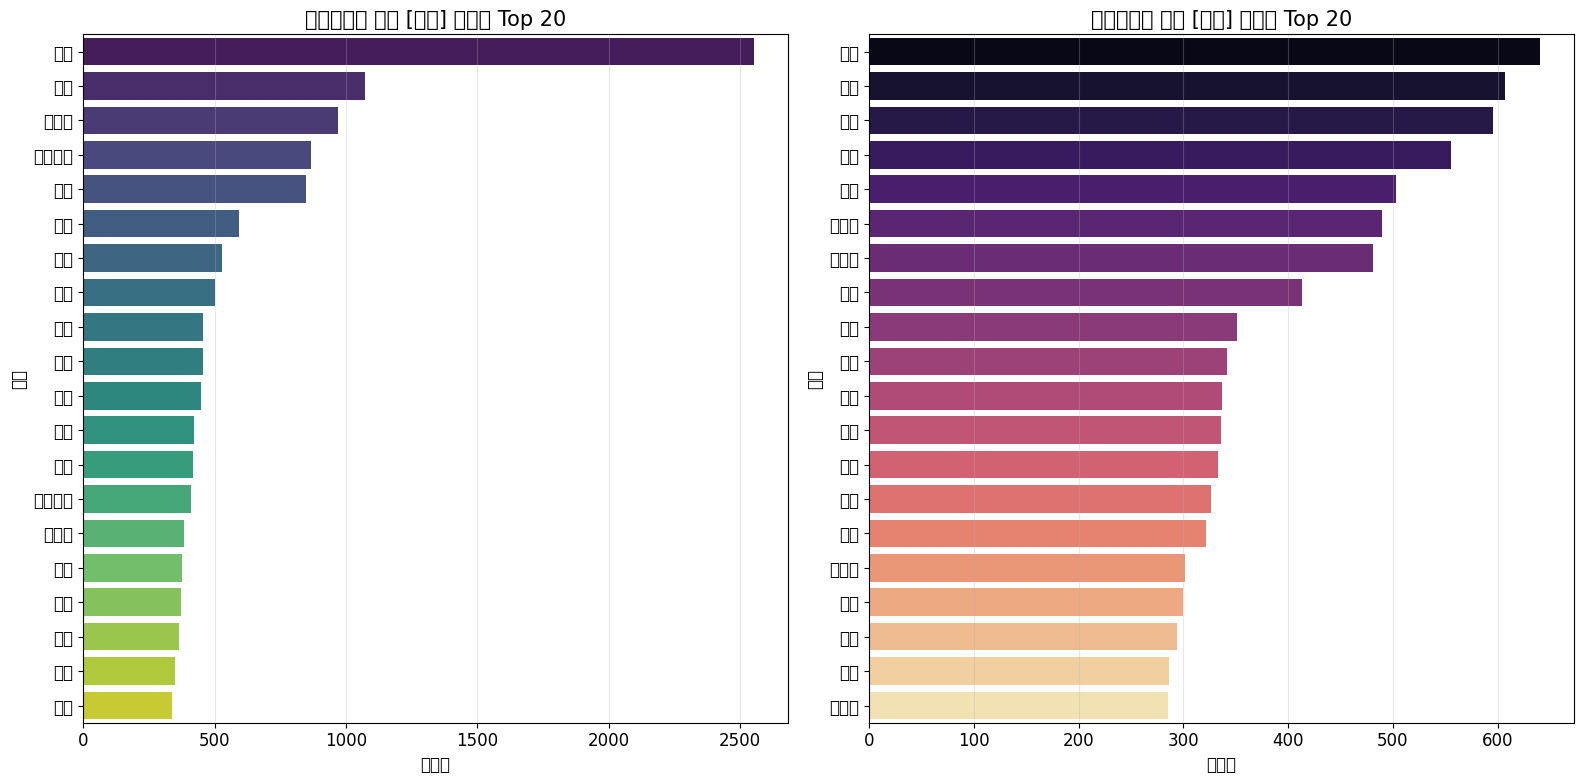

In [15]:
# 필요한 라이브러리: !pip install konlpy seaborn pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from collections import Counter
import os

# ==========================================
# 1. 한글 폰트 설정
# ==========================================
def set_korean_font():
    if os.name == 'posix':  # Mac or Colab
        try:
            plt.rc('font', family='NanumBarunGothic')
        except:
            plt.rc('font', family='AppleGothic')
    elif os.name == 'nt':  # Windows
        plt.rc('font', family='Malgun Gothic')
    plt.rc('axes', unicode_minus=False)

set_korean_font()

# ==========================================
# 2. 데이터 로드
# ==========================================
file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    df = pd.read_excel(file_path)
    # 결측치(빈 값)를 공백으로 채움
    df['장점'] = df['장점'].fillna('')
    df['단점'] = df['단점'].fillna('')
    print("파일 로드 완료.")
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다.")
    raise

# ==========================================
# 3. 핵심 로직: 형태소 분석 및 불용어 제거
# ==========================================
okt = Okt()

# 분석에서 제외할 단어 리스트
# 분석에 있어 정보적 가치가 딱히 없는 것들
stop_words = [
    '하다', '있다', '없다', '되다', '같다', '이다',  # 서술어
    '회사', '직원', '업무', '사람', '기업',         # 일반 명사 (너무 뻔한 단어)
    '정도', '생각', '부분', '느낌', '많다', '적다', # 추상적 표현
    '매우', '정말', '진짜', '가다', '오다',         # 부사 및 기타
    '곳', '것', '수'                               # 의존 명사
]

def analyze_word_frequency(text_series, top_n=20):
    """
    텍스트 데이터에서 명사와 형용사를 추출하고,
    불용어를 제거한 뒤 빈도수 상위 단어를 반환합니다.
    """
    print(" -> 텍스트 분석을 시작합니다 (데이터 양에 따라 시간이 걸릴 수 있습니다)...")

    # 1. 모든 텍스트를 하나의 긴 문자열로 합침
    full_text = " ".join(text_series.astype(str))

    # 2. 형태소 분석 (Stemming=True: '합니다' -> '하다'로 원형 복원)
    # 명사(Noun)와 형용사(Adjective)만 추출
    tokens = okt.pos(full_text, stem=True)
    words = [word for word, tag in tokens if tag in ['Noun', 'Adjective'] and len(word) > 1]

    # 3. 불용어 제거 (핵심 단계)
    filtered_words = [w for w in words if w not in stop_words]

    # 4. 빈도수 계산
    return Counter(filtered_words).most_common(top_n)

# ==========================================
# 4. 실행 및 결과 출력 (텍스트 & 시각화)
# ==========================================

# (1) 장점 분석
print("\n[장점] 키워드 분석 중...")
pros_top20 = analyze_word_frequency(df['장점'], top_n=20)

print("\n>>> 장점 상위 20개 단어와 빈도수:")
for word, count in pros_top20:
    print(f"{word}: {count}회")

# (2) 단점 분석
print("\n[단점] 키워드 분석 중...")
cons_top20 = analyze_word_frequency(df['단점'], top_n=20)

print("\n>>> 단점 상위 20개 단어와 빈도수:")
for word, count in cons_top20:
    print(f"{word}: {count}회")

# (3) 시각화 (막대 그래프)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 장점 그래프
df_pros = pd.DataFrame(pros_top20, columns=['단어', '빈도수'])
sns.barplot(x='빈도수', y='단어', data=df_pros, ax=axes[0], palette='viridis')
axes[0].set_title('직장인들이 뽑은 [장점] 키워드 Top 20', fontsize=15)
axes[0].grid(axis='x', alpha=0.3)

# 단점 그래프
df_cons = pd.DataFrame(cons_top20, columns=['단어', '빈도수'])
sns.barplot(x='빈도수', y='단어', data=df_cons, ax=axes[1], palette='magma')
axes[1].set_title('직장인들이 뽑은 [단점] 키워드 Top 20', fontsize=15)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

데이터 로드 및 전처리 완료. (분석 그룹 수: 986)
PCA 및 클러스터링 진행 중...
클러스터링 완료. 텍스트 분석을 시작합니다.


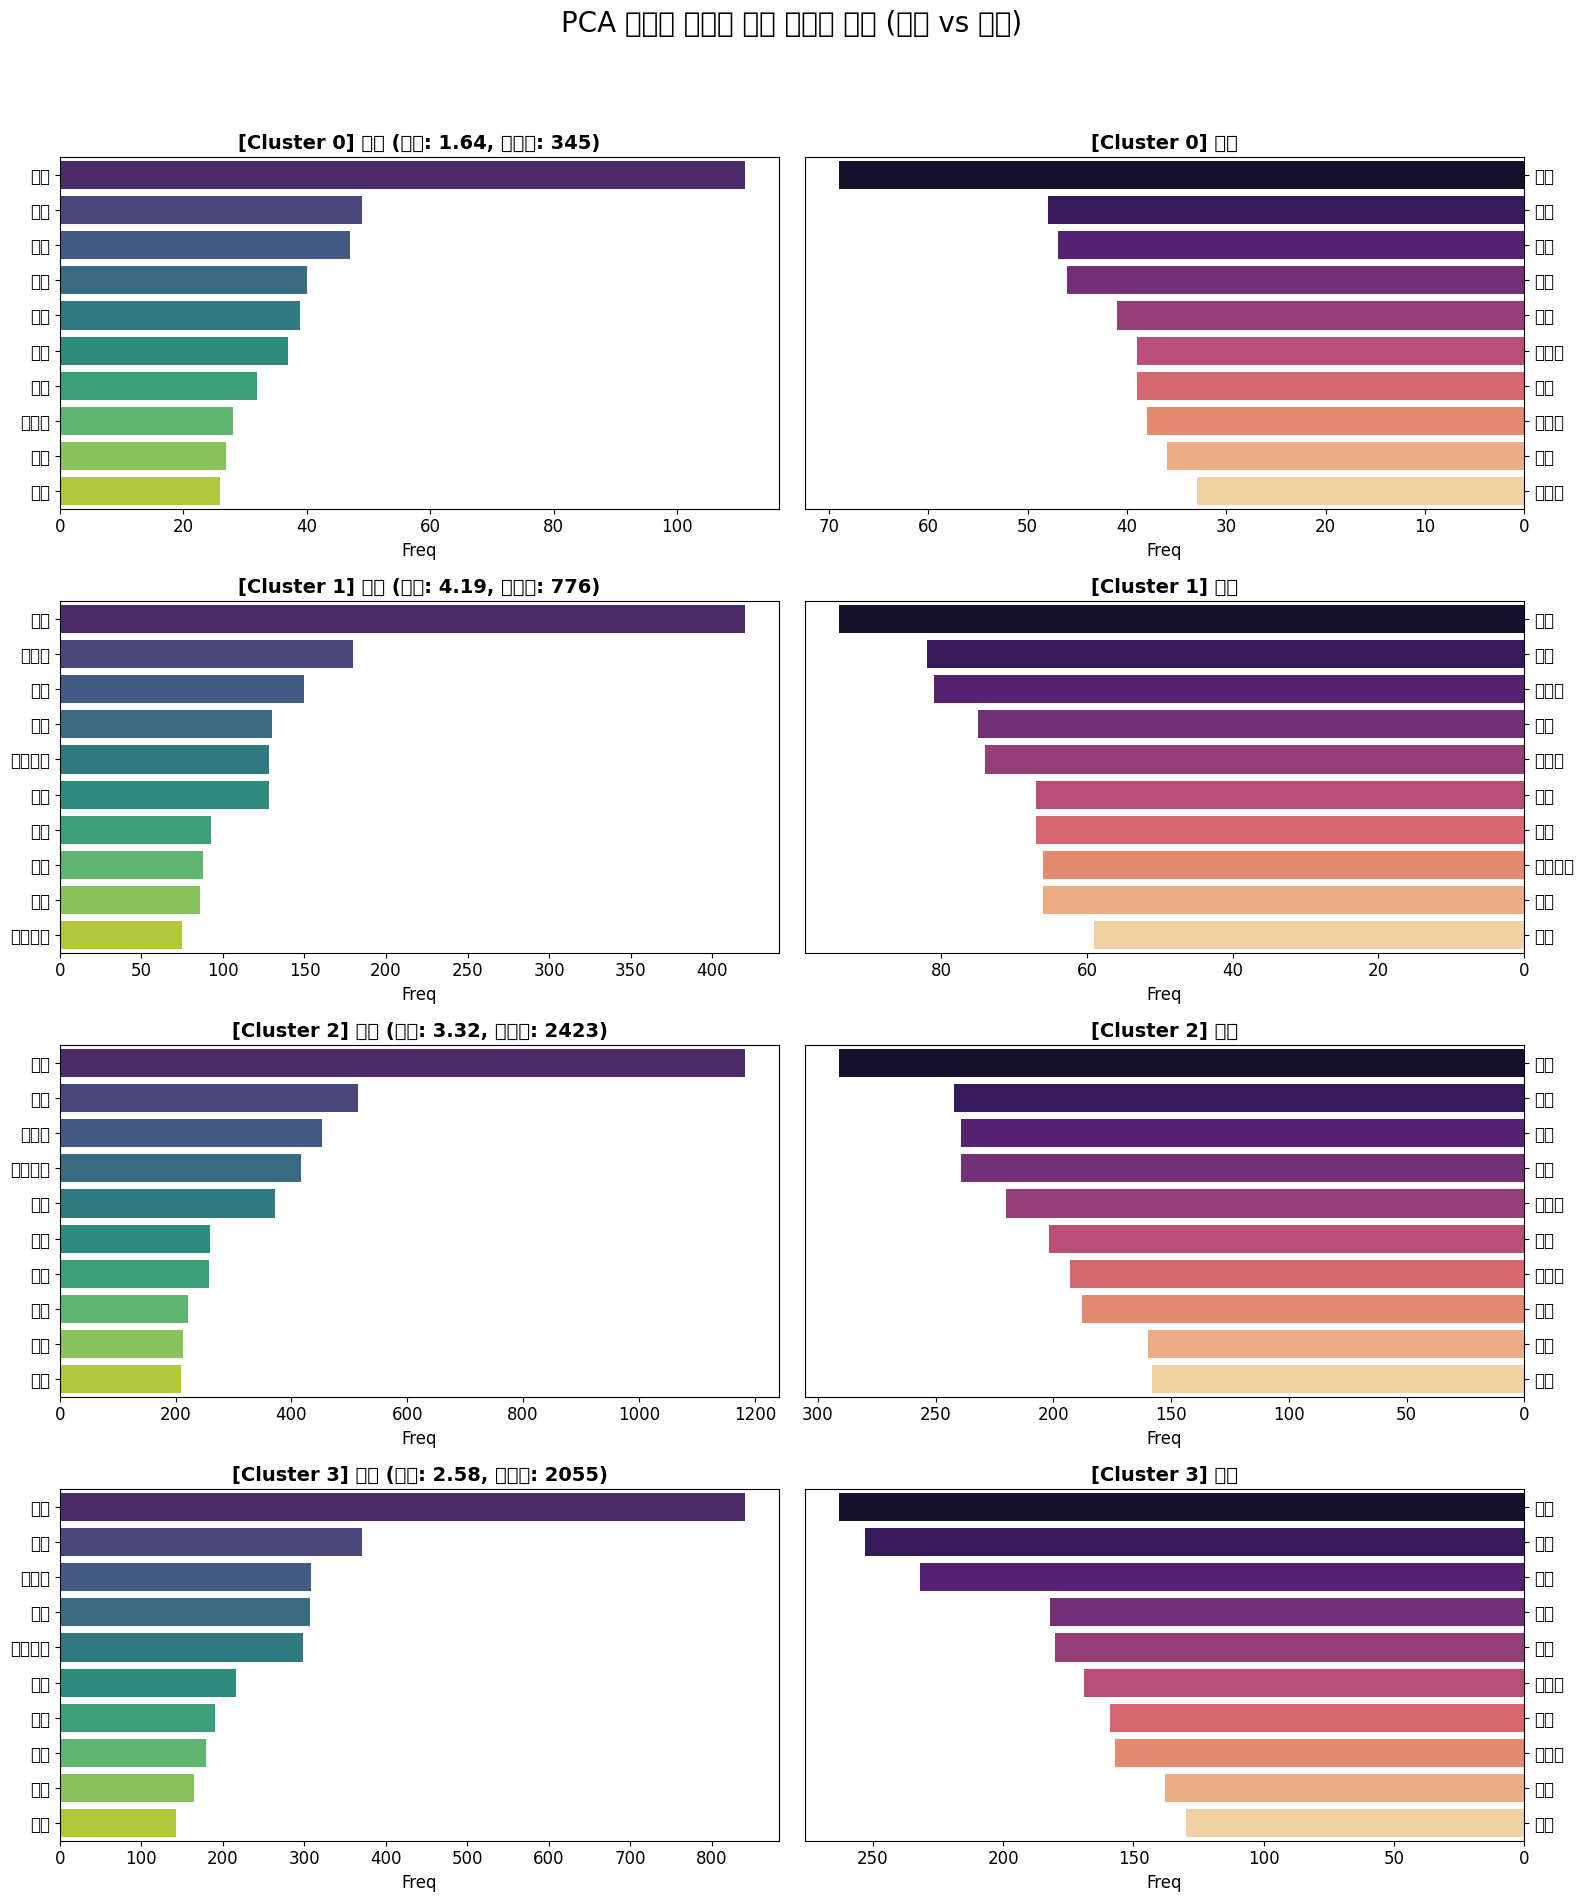


[분석 결과 해석 가이드]
각 Cluster(군집)의 장단점 키워드를 비교해보세요.
1. 상위권 그룹(높은 평점)의 '단점'은 무엇인가요? (예: '업무량', '바쁨' 등 '성장통'에 가까운 단어인지?)
2. 하위권 그룹(낮은 평점)의 '단점'은 무엇인가요? (예: '꼰대', '정치', '체계' 등 구조적 문제인지?)
3. 특정 그룹에서만 도드라지는 키워드가 있나요? (예: '재택', '회식', '연봉' 등)


In [16]:
# 필요한 라이브러리: !pip install konlpy seaborn pandas matplotlib scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from konlpy.tag import Okt
from collections import Counter
import os
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. 한글 폰트 설정
# ==========================================
def set_korean_font():
    if os.name == 'posix':  # Mac or Colab
        try:
            plt.rc('font', family='NanumBarunGothic')
        except:
            plt.rc('font', family='AppleGothic')
    elif os.name == 'nt':  # Windows
        plt.rc('font', family='Malgun Gothic')
    plt.rc('axes', unicode_minus=False)

set_korean_font()

# ==========================================
# 2. 데이터 로드 및 전처리 (PCA 준비)
# ==========================================
file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    df = pd.read_excel(file_path)
    # 텍스트 결측치 처리
    df['장점'] = df['장점'].fillna('')
    df['단점'] = df['단점'].fillna('')

    # 수치형 데이터 전처리
    score_cols = ['salary_benefits', 'work_life_balance', 'culture', 'leadership', 'promotion_opportunity', 'overall_rating']

    # 컬럼명 매핑 (한글 -> 영문) 확인 및 변경
    rename_map = {
        '복지 및 급여': 'salary_benefits', '업무와 삶의 균형': 'work_life_balance',
        '사내문화': 'culture', '경영진': 'leadership',
        '승진 기회': 'promotion_opportunity', '종합평점': 'overall_rating',
        '구분': 'job_role', '기업명': 'company'
    }
    # 컬럼 공백 제거
    df.columns = [str(col).strip() for col in df.columns]
    df = df.rename(columns=rename_map)

    # 수치형 변환
    for col in score_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=score_cols + ['company', 'job_role'])

    # 분석 단위 생성 (회사_직무)
    df['job_company'] = df['company'] + "_" + df['job_role']

    # 그룹별 평균 산출 (PCA용)
    summary_df = df.groupby('job_company')[score_cols].mean().reset_index()

    print(f"데이터 로드 및 전처리 완료. (분석 그룹 수: {len(summary_df)})")

except Exception as e:
    print(f"데이터 처리 중 오류 발생: {e}")
    raise

# ==========================================
# 3. PCA 및 K-Means 클러스터링
# ==========================================
print("PCA 및 클러스터링 진행 중...")

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(summary_df[score_cols])

# PCA (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
summary_df['PC1'] = pca_result[:, 0]
summary_df['PC2'] = pca_result[:, 1]

# K-Means (4개 그룹)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
summary_df['Cluster'] = kmeans.fit_predict(X_scaled)

# 원본 데이터에 Cluster 정보 매핑
cluster_map = summary_df.set_index('job_company')['Cluster'].to_dict()
df['Cluster'] = df['job_company'].map(cluster_map)

print("클러스터링 완료. 텍스트 분석을 시작합니다.")

# ==========================================
# 4. 군집별 텍스트 분석 (키워드 추출)
# ==========================================
okt = Okt()
stop_words = ['하다', '있다', '없다', '되다', '같다', '이다', '회사', '직원', '업무', '사람', '기업', '정도', '생각', '부분', '느낌', '많다', '적다', '매우', '정말', '진짜', '곳', '것', '수']

def get_keywords(text_series, top_n=10):
    """특정 텍스트 시리즈에서 상위 키워드 추출"""
    full_text = " ".join(text_series.astype(str))
    tokens = okt.pos(full_text, stem=True)
    words = [word for word, tag in tokens if tag in ['Noun', 'Adjective'] and len(word) > 1 and word not in stop_words]
    return Counter(words).most_common(top_n)

# 군집별 데이터 저장소
cluster_analysis = {}

for cluster_id in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == cluster_id]

    # 장점 키워드
    pros = get_keywords(subset['장점'])
    # 단점 키워드
    cons = get_keywords(subset['단점'])
    # 평점 평균 (참고용)
    avg_rating = subset['overall_rating'].mean()

    cluster_analysis[cluster_id] = {
        'pros': pros,
        'cons': cons,
        'rating': avg_rating,
        'count': len(subset)
    }

# ==========================================
# 5. 시각화 (군집별 장/단점 비교)
# ==========================================
# 4개 군집 * 2개(장/단점) 그래프
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('PCA 군집별 직장인 리뷰 키워드 분석 (장점 vs 단점)', fontsize=20)

clusters = sorted(cluster_analysis.keys())

for i, cluster_id in enumerate(clusters):
    data = cluster_analysis[cluster_id]

    # [왼쪽] 장점 그래프
    pros_df = pd.DataFrame(data['pros'], columns=['Word', 'Freq'])
    sns.barplot(x='Freq', y='Word', data=pros_df, ax=axes[i][0], palette='viridis')
    axes[i][0].set_title(f"[Cluster {cluster_id}] 장점 (평점: {data['rating']:.2f}, 리뷰수: {data['count']})", fontsize=14, fontweight='bold')
    axes[i][0].set_ylabel('')

    # [오른쪽] 단점 그래프
    cons_df = pd.DataFrame(data['cons'], columns=['Word', 'Freq'])
    sns.barplot(x='Freq', y='Word', data=cons_df, ax=axes[i][1], palette='magma')
    axes[i][1].set_title(f"[Cluster {cluster_id}] 단점", fontsize=14, fontweight='bold')
    axes[i][1].set_ylabel('')
    axes[i][1].invert_xaxis() # 단점은 그래프 방향을 반대로 하여 대칭효과 (선택사항)
    axes[i][1].yaxis.tick_right() # y축 라벨 오른쪽으로 이동

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==========================================
# 6. 해석 가이드 출력
# ==========================================
print("\n" + "="*60)
print("[분석 결과 해석 가이드]")
print("="*60)
print("각 Cluster(군집)의 장단점 키워드를 비교해보세요.")
print("1. 상위권 그룹(높은 평점)의 '단점'은 무엇인가요? (예: '업무량', '바쁨' 등 '성장통'에 가까운 단어인지?)")
print("2. 하위권 그룹(낮은 평점)의 '단점'은 무엇인가요? (예: '꼰대', '정치', '체계' 등 구조적 문제인지?)")
print("3. 특정 그룹에서만 도드라지는 키워드가 있나요? (예: '재택', '회식', '연봉' 등)")

In [17]:
# 필요한 라이브러리: !pip install konlpy pandas scikit-learn

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from konlpy.tag import Okt
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. 데이터 로드 및 전처리 (PCA 준비)
# ==========================================
file_path = '통합_리뷰_기업중복제거.xlsx'

try:
    df = pd.read_excel(file_path)
    # 텍스트 결측치 처리
    df['장점'] = df['장점'].fillna('')
    df['단점'] = df['단점'].fillna('')

    # 수치형 데이터 전처리
    score_cols = ['salary_benefits', 'work_life_balance', 'culture', 'leadership', 'promotion_opportunity', 'overall_rating']

    # 컬럼명 매핑 (한글 -> 영문) 확인 및 변경
    rename_map = {
        '복지 및 급여': 'salary_benefits', '업무와 삶의 균형': 'work_life_balance',
        '사내문화': 'culture', '경영진': 'leadership',
        '승진 기회': 'promotion_opportunity', '종합평점': 'overall_rating',
        '구분': 'job_role', '기업명': 'company'
    }
    # 컬럼 공백 제거
    df.columns = [str(col).strip() for col in df.columns]
    df = df.rename(columns=rename_map)

    # 수치형 변환
    for col in score_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=score_cols + ['company', 'job_role'])

    # 분석 단위 생성 (회사_직무)
    df['job_company'] = df['company'] + "_" + df['job_role']

    # 그룹별 평균 산출 (PCA용)
    summary_df = df.groupby('job_company')[score_cols].mean().reset_index()

    print(f"데이터 로드 및 전처리 완료. (분석 그룹 수: {len(summary_df)})")

except Exception as e:
    print(f"데이터 처리 중 오류 발생: {e}")
    raise

# ==========================================
# 2. PCA 및 K-Means 클러스터링
# ==========================================
print("PCA 및 클러스터링 진행 중...")

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(summary_df[score_cols])

# PCA (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
summary_df['PC1'] = pca_result[:, 0]
summary_df['PC2'] = pca_result[:, 1]

# K-Means (4개 그룹)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
summary_df['Cluster'] = kmeans.fit_predict(X_scaled)

# 원본 데이터에 Cluster 정보 매핑
cluster_map = summary_df.set_index('job_company')['Cluster'].to_dict()
df['Cluster'] = df['job_company'].map(cluster_map)

print("클러스터링 완료. 텍스트 분석을 시작합니다.")

# ==========================================
# 3. 군집별 텍스트 분석 (키워드 추출)
# ==========================================
okt = Okt()
stop_words = ['하다', '있다', '없다', '되다', '같다', '이다', '회사', '직원', '업무', '사람', '기업', '정도', '생각', '부분', '느낌', '많다', '적다', '매우', '정말', '진짜', '곳', '것', '수']

def get_keywords(text_series, top_n=10):
    """특정 텍스트 시리즈에서 상위 키워드 추출"""
    full_text = " ".join(text_series.astype(str))
    tokens = okt.pos(full_text, stem=True)
    words = [word for word, tag in tokens if tag in ['Noun', 'Adjective'] and len(word) > 1 and word not in stop_words]
    return Counter(words).most_common(top_n)

# 군집별 데이터 저장소 및 출력
print("\n" + "="*60)
print("■ PCA 군집별 직장인 리뷰 분석 결과 (텍스트 리포트)")
print("="*60)

for cluster_id in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == cluster_id]

    # 장점 키워드
    pros = get_keywords(subset['장점'], top_n=10)
    # 단점 키워드
    cons = get_keywords(subset['단점'], top_n=10)
    # 평점 평균
    avg_rating = subset['overall_rating'].mean()

    print(f"\n[Cluster {cluster_id}] 요약")
    print(f" - 평균 종합평점: {avg_rating:.2f}점")
    print(f" - 리뷰 데이터 수: {len(subset)}건")

    print(f"\n  ▶ 주요 장점 키워드 (Top 10)")
    pros_str = ", ".join([f"{word}({count})" for word, count in pros])
    print(f"    {pros_str}")

    print(f"\n  ▶ 주요 단점 키워드 (Top 10)")
    cons_str = ", ".join([f"{word}({count})" for word, count in cons])
    print(f"    {cons_str}")

    print("-" * 60)

# ==========================================
# 4. 해석 가이드 출력
# ==========================================
print("\n[분석 결과 해석 가이드]")
print("1. 각 군집(Cluster)의 평균 점수를 보고 상위권/하위권 그룹을 파악하세요.")
print("2. 상위권 그룹의 '단점' 키워드가 무엇인지 확인하세요 (예: '업무량' vs '체계').")
print("3. 하위권 그룹의 '단점' 키워드에서 치명적인 문제(예: '꼰대', '정치', '급여')를 찾으세요.")
print("4. 특정 그룹에만 나타나는 독특한 장점(예: '재택', '자율')이 있는지 확인하세요.")

데이터 로드 및 전처리 완료. (분석 그룹 수: 986)
PCA 및 클러스터링 진행 중...
클러스터링 완료. 텍스트 분석을 시작합니다.

■ PCA 군집별 직장인 리뷰 분석 결과 (텍스트 리포트)

[Cluster 0] 요약
 - 평균 종합평점: 1.64점
 - 리뷰 데이터 수: 345건

  ▶ 주요 장점 키워드 (Top 10)
    좋다(111), 간식(49), 장점(47), 연차(40), 제공(39), 복지(37), 사용(32), 분위기(28), 근무(27), 점심(26)

  ▶ 주요 단점 키워드 (Top 10)
    야근(69), 퇴사(48), 연봉(47), 복지(46), 좋다(41), 분위기(39), 체계(39), 아니다(38), 대표(36), 그렇다(33)
------------------------------------------------------------

[Cluster 1] 요약
 - 평균 종합평점: 4.19점
 - 리뷰 데이터 수: 776건

  ▶ 주요 장점 키워드 (Top 10)
    좋다(420), 분위기(180), 복지(150), 문화(130), 자유롭다(128), 연차(128), 동료(93), 사용(88), 지원(86), 성장하다(75)

  ▶ 주요 단점 키워드 (Top 10)
    좋다(94), 체계(82), 아니다(81), 단점(75), 분위기(74), 성장(67), 야근(67), 스타트업(66), 높다(66), 경우(59)
------------------------------------------------------------

[Cluster 2] 요약
 - 평균 종합평점: 3.32점
 - 리뷰 데이터 수: 2423건

  ▶ 주요 장점 키워드 (Top 10)
    좋다(1183), 복지(515), 분위기(453), 자유롭다(416), 연차(371), 문화(260), 사용(257), 동료(222), 지원(213), 근무(210)

  ▶ 주요 단점 키워드 (Top 10)
    연봉(291), 복지(2

이상의 기본적인 데이터 분석을 이용한 목표 모델의 실사용 예시입니다. 아직 모델 학습 방향을 확정하지는 못했기에 기존의 언어모델을 사용하는 과정을 거쳤습니다.

데이터 병합 완료.

■ 사전 분석: 전체 데이터의 장점 vs 단점 키워드 추출
[1/2] '장점' 텍스트 분석 중...
 -> 형태소 분석 중... (데이터 양에 따라 시간이 소요될 수 있습니다)
[2/2] '단점' 텍스트 분석 중...
 -> 형태소 분석 중... (데이터 양에 따라 시간이 소요될 수 있습니다)


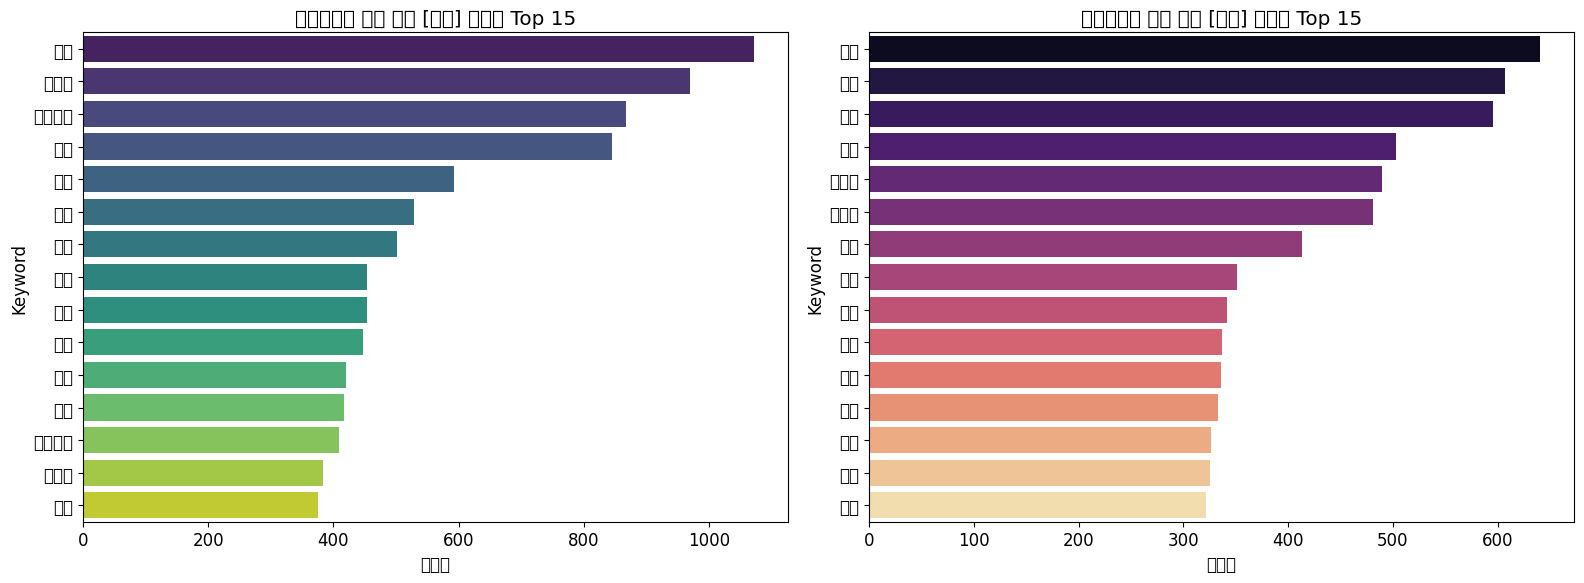

 -> 텍스트 분석 시각화 완료. 이제 딥러닝 모델을 로드합니다.

Loading SBERT model (jhgan/ko-sbert-multitask) on cpu...
Model loaded successfully.
기업 리뷰 데이터를 벡터화 중입니다...
벡터화 완료!

■ AI 기반 자연어 직무 추천 시스템 데모
[사용자 입력 문장]:
수직적이지 않고 서로 영어 이름을 부르는 수평적인 문화를 원해요. 
연봉은 업계 평균 정도면 되고, 야근이 있더라도 배울 수 있는게 많은 성장 가능한 곳이었으면 좋겠습니다.
꼰대 문화나 회식 강요는 정말 싫습니다.
--------------------------------------------------
... 분석 중 ...

[AI 추천 결과 Top 5]
1위: (주)와탭랩스_영업/제휴
   - 적합도: 0.7914 (리뷰 유사도: 0.6523)
   - 평점: 5.0 / 군집 유형: Cluster 1
2위: (주)뷰노_법률/법무
   - 적합도: 0.7625 (리뷰 유사도: 0.6041)
   - 평점: 5.0 / 군집 유형: Cluster 1
3위: (주)에어스메디컬_연구개발
   - 적합도: 0.7617 (리뷰 유사도: 0.6205)
   - 평점: 5.0 / 군집 유형: Cluster 1
4위: 위시켓(주)_데이터
   - 적합도: 0.7577 (리뷰 유사도: 0.6629)
   - 평점: 5.0 / 군집 유형: Cluster 1
5위: (주)녹십자홀딩스_디자인
   - 적합도: 0.7512 (리뷰 유사도: 0.5853)
   - 평점: 5.0 / 군집 유형: Cluster 1


In [14]:
# 필요한 라이브러리 설치
# !pip install konlpy wordcloud sentence-transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import torch
import warnings
import os

warnings.filterwarnings("ignore")

# ==================================================
# 0. 폰트 설정 (한글 깨짐 방지)
# ==================================================
def set_korean_font():
    if os.name == 'posix':  # Mac or Colab
        try:
            plt.rc('font', family='NanumBarunGothic')
        except:
            plt.rc('font', family='AppleGothic')
    elif os.name == 'nt':  # Windows
        plt.rc('font', family='Malgun Gothic')
    plt.rc('axes', unicode_minus=False)

set_korean_font()

# ==================================================
# 1. 데이터 병합 (앞선 PCA/군집분석 결과 + 원본 텍스트)
# ==================================================

try:
    # 앞선 코드의 summary_df에서 cluster 정보만 가져오기
    cluster_map = summary_df[['job_company', 'Cluster']].set_index('job_company')['Cluster'].to_dict()

    # 원본 df에 Cluster 컬럼 추가
    df['Cluster'] = df['job_company'].map(cluster_map)

    # 텍스트 데이터 전처리 (NaN 처리)
    df['장점'] = df['장점'].fillna('')
    df['단점'] = df['단점'].fillna('')
    df['요약'] = df['요약'].fillna('')

    # 전체 통합 텍스트 (임베딩용)
    df['full_text'] = df['장점'] + " " + df['단점'] + " " + df['요약']

    # 분석 단위인 'job_company' 별로 텍스트를 모두 합침
    df_grouped_text = df.groupby('job_company')['full_text'].apply(lambda x: " ".join(x)).reset_index()

    # 정량 데이터(summary_df)와 텍스트 데이터(df_grouped_text) 병합
    final_df = pd.merge(summary_df, df_grouped_text, on='job_company')

    print("데이터 병합 완료.")

except NameError:
    print("오류: 이전 단계의 'df' 또는 'summary_df' 변수가 없습니다. PCA 분석 코드를 먼저 실행해주세요.")
    raise

# ==================================================
# 2. [시각화] 직무 데이터 장/단점 텍스트 분석 과정
# ==================================================
print("\n" + "="*60)
print("■ 사전 분석: 전체 데이터의 장점 vs 단점 키워드 추출")
print("="*60)

okt = Okt()

def get_top_keywords(text_series, top_n=20):
    """텍스트 시리즈에서 명사/형용사 추출 후 상위 빈도 단어 반환"""
    print(" -> 형태소 분석 중... (데이터 양에 따라 시간이 소요될 수 있습니다)")
    total_text = " ".join(text_series.astype(str))

    # 명사, 형용사 추출
    tokens = okt.pos(total_text, stem=True)
    words = [word for word, tag in tokens if tag in ['Noun', 'Adjective'] and len(word) > 1]

    # 불용어(Stopwords) 제거
    stop_words = ['하다', '있다', '없다', '적다', '많다', '좋다', '회사', '직원', '업무', '사람', '생각', '정도', '기업', '같다', '이다', '되다', '오다', '가다']
    words = [w for w in words if w not in stop_words]

    return Counter(words).most_common(top_n)

# 1) 장점 키워드 분석
print("[1/2] '장점' 텍스트 분석 중...")
pros_keywords = get_top_keywords(df['장점'], top_n=15)

# 2) 단점 키워드 분석
print("[2/2] '단점' 텍스트 분석 중...")
cons_keywords = get_top_keywords(df['단점'], top_n=15)

# 3) 시각화 (Bar Plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 장점 그래프
pros_df = pd.DataFrame(pros_keywords, columns=['Keyword', 'Frequency'])
sns.barplot(x='Frequency', y='Keyword', data=pros_df, ax=axes[0], palette='viridis')
axes[0].set_title('직장인들이 꼽은 주요 [장점] 키워드 Top 15')
axes[0].set_xlabel('빈도수')

# 단점 그래프
cons_df = pd.DataFrame(cons_keywords, columns=['Keyword', 'Frequency'])
sns.barplot(x='Frequency', y='Keyword', data=cons_df, ax=axes[1], palette='magma')
axes[1].set_title('직장인들이 꼽은 주요 [단점] 키워드 Top 15')
axes[1].set_xlabel('빈도수')

plt.tight_layout()
plt.show()

print(" -> 텍스트 분석 시각화 완료. 이제 딥러닝 모델을 로드합니다.")

# ==================================================
# 3.  [NLP] Sentence-BERT 기반 임베딩 모델 로드
# ==================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'jhgan/ko-sbert-multitask'

try:
    print(f"\nLoading SBERT model ({model_name}) on {device}...")
    sbert_model = SentenceTransformer(model_name, device=device)
    print("Model loaded successfully.")
except Exception as e:
    print(f"모델 로드 중 오류 발생: {e}")
    raise

# ==================================================
# 4. 기업 리뷰 데이터 벡터화 (Embedding)
# ==================================================
print("기업 리뷰 데이터를 벡터화 중입니다...")
company_reviews = final_df['full_text'].tolist()
company_embeddings = sbert_model.encode(company_reviews, convert_to_tensor=True)
print("벡터화 완료!")

# ==================================================
# 5. [고도화] 자연어 서술 기반 하이브리드 추천 엔진
# ==================================================

def advanced_recommendation(user_description, user_weights, data_df, embeddings, top_k=5):
    """
    사용자의 자연어 서술(Description)과 가중치(Weights)를 결합한 하이브리드 추천 시스템
    """

    # A. 의미적 유사도 점수
    user_embedding = sbert_model.encode(user_description, convert_to_tensor=True)
    cos_scores = util.cos_sim(user_embedding, embeddings)[0]
    data_df['similarity_score'] = cos_scores.cpu().numpy()

    # B. 정량적 적합도 점수 (0~1 정규화)
    max_rating = 5.0
    data_df['quant_score'] = (
        (data_df['salary_benefits'] * user_weights.get('salary', 0)) +
        (data_df['work_life_balance'] * user_weights.get('balance', 0)) +
        (data_df['culture'] * user_weights.get('culture', 0)) +
        (data_df['leadership'] * user_weights.get('leadership', 0)) +
        (data_df['promotion_opportunity'] * user_weights.get('growth', 0))
    ) / max_rating

    # C. 최종 하이브리드 점수 (텍스트 60% + 정량 40%)
    alpha = 0.6
    beta = 0.4
    data_df['final_score'] = (data_df['similarity_score'] * alpha) + (data_df['quant_score'] * beta)

    # 상위 k개 추천
    results = data_df.sort_values(by='final_score', ascending=False).head(top_k)
    return results[['job_company', 'final_score', 'similarity_score', 'overall_rating', 'Cluster']]

# ==================================================
# 6. 실사용 시나리오 테스트
# ==================================================

print("\n" + "="*60)
print("■ AI 기반 자연어 직무 추천 시스템 데모")
print("="*60)

# [사용자 입력]
user_desc_input = """
수직적이지 않고 서로 영어 이름을 부르는 수평적인 문화를 원해요.
연봉은 업계 평균 정도면 되고, 야근이 있더라도 배울 수 있는게 많은 성장 가능한 곳이었으면 좋겠습니다.
꼰대 문화나 회식 강요는 정말 싫습니다.
"""

# [사용자 가중치]
user_pref_weights = {
    'salary': 0.2,
    'balance': 0.1,
    'culture': 0.4,
    'leadership': 0.0,
    'growth': 0.3
}

print(f"[사용자 입력 문장]:\n{user_desc_input.strip()}")
print("-" * 50)
print("... 분석 중 ...")

# 추천 실행
recommendations = advanced_recommendation(
    user_desc_input,
    user_pref_weights,
    final_df,
    company_embeddings,
    top_k=5
)

# 결과 출력
print("\n[AI 추천 결과 Top 5]")
rank = 1
for idx, row in recommendations.iterrows():
    print(f"{rank}위: {row['job_company']}")
    print(f"   - 적합도: {row['final_score']:.4f} (리뷰 유사도: {row['similarity_score']:.4f})")
    print(f"   - 평점: {row['overall_rating']:.1f} / 군집 유형: Cluster {row['Cluster']}")
    rank += 1

In [11]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 31.4 MB/s eta 0:00:00
